In [1]:
cd ..

/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp


In [2]:
import os
from typing import Optional

import numpy as np
import h5py
import json
import glob

# For inference
import pymc as pm
import arviz as az

# For loading data
from matter_multi_fidelity_emu.data_loader_dgmgp import interpolate
from matter_multi_fidelity_emu.plottings.validation_loader import ValidationLoader
from matter_multi_fidelity_emu.data_loader import folder_name

from examples.make_plots_pipeline import PreloadedVloaders

In [3]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams.update(
    {"font.size": 16, "axes.labelsize": 24, "axes.titlesize": 18, "text.usetex": True,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.2, "ytick.major.width": 1.5, "ytick.minor.width": 1.2,
    "legend.fontsize": 18}
)

# colors to use
c_flatirons = '#8B2131'
c_sunshine = '#CA9500'
c_skyline = '#1D428A'
c_midnight = '#0E2240'

colors = [c_flatirons, c_sunshine, c_skyline, c_midnight]

# acronym
mf_box = "MF-Box"

# useful throughout
base_dir = '/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/data/'
emudir = '/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/data/dmo_60_res128box256/'
imgdir = '/Users/jibanmac/Documents/Latex/mf_boxsize_paper/images/'
zz = np.array([0, 0.2, 0.5, 1.0, 2.0, 3.0])
test = h5py.File(emudir+'cc_emulator_powerspecs.hdf5', 'r')
kf_test = test['kfmpc'][:]
test.close()

## Collect emulation results from various emulators


In [4]:
# Let's follow Martin's convention and organize the necessary emulators to one variable
# Note: I used to run more emulators than necessary, so I have to specify the folders I want to read
# instead of reading everything in the based_dir


In [5]:
# preloading the validation results
vloaders = PreloadedVloaders()


 /Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/matter_multi_fidelity_emu/plottings/validation_loader.py:149: RuntimeWarning:overflow encountered in power
 /Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/matter_multi_fidelity_emu/plottings/validation_loader.py:133: RuntimeWarning:invalid value encountered in divide


## Figure 1: Power Spectra Comparison

It's better to follow the order of the paper, so it's easier to debug in the future.


In [6]:
def interp_lf_trim_hf(
    k_lf: np.ndarray, k_hf: np.ndarray, Y_lf: np.ndarray, Y_hf: np.ndarray
):
    # Interpolate the LF,
    # and limit the HF kmax to the maximum of LF
    # Min k bins LF <= k bins HF <= Max k bins LF
    ind_min = (np.log10(k_lf).min() <= np.log10(k_hf)) & (
        np.log10(k_hf) <= np.log10(k_lf).max()
    )

    # interpolate: interp(log10_k, Y_lf)(log10_k[ind_min])
    # I do want to interpolate in loglog scale.
    # TODO: Think about if our smooth prior is on linear or log scale?
    Y_lf_new = interpolate(np.log10(k_lf), np.log10(Y_lf), np.log10(k_hf)[ind_min])
    Y_lf = 10**Y_lf_new
    Y_hf = Y_hf[:, ind_min]
    k_hf = k_hf[ind_min]
    k_lf = k_hf

    return k_lf, k_hf, Y_lf, Y_hf, ind_min

96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.


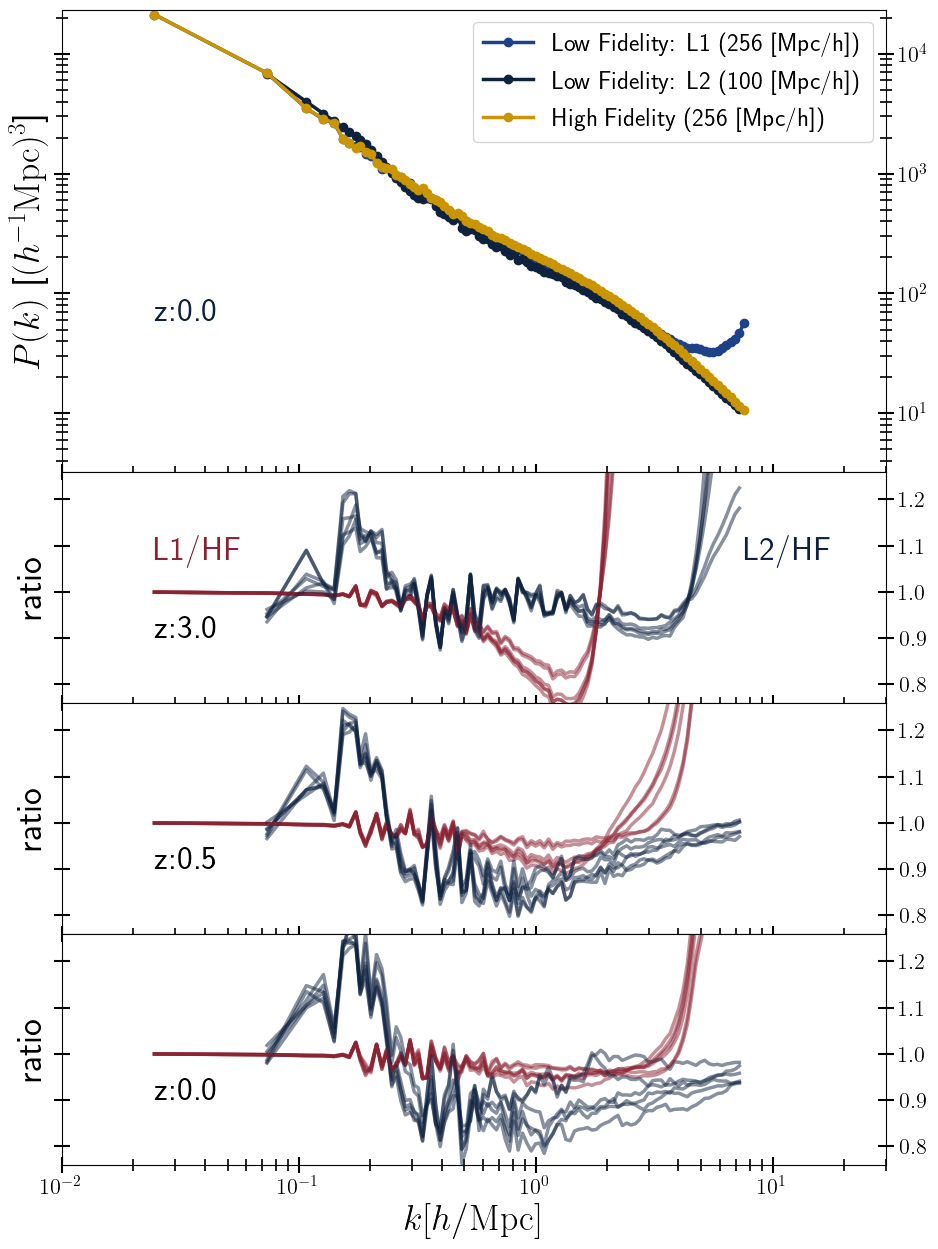

In [13]:
# plot the difference between HF and LF for each simulation pair available

# lores, hires indices: 0:18, 1:4, 2:17, 3:36, 4:26, 5:1
hires = h5py.File("data/dmo_24_res512box256/cc_emulator_powerspecs.hdf5", "r")
hrfp, hrkf = hires["powerspecs"][:], hires["kfmpc"][:]
selected_ind = hires["selected_ind"][:]
hires.close()

lores = h5py.File("data/dmo_60_res128box256/cc_emulator_powerspecs.hdf5", "r")
lrfp, lrkf = lores["powerspecs"][:], lores["kfmpc"][:]
lores.close()

lores_2 = h5py.File("data/dmo_60_res128box100/cc_emulator_powerspecs.hdf5", "r")
lrfp_2, lrkf_2 = lores_2["powerspecs"][:], lores_2["kfmpc"][:]
lores_2.close()


# make interpolation to make sure lr and hr have the same shape
## Start here
## -------------
axis_redshift = 1
num_redshifts = hrfp.shape[axis_redshift]

# L1 and HF
this_lrkf, this_hrkf, this_lrfp, this_hrfp, ind = interp_lf_trim_hf(
    k_lf=lrkf, k_hf=hrkf, Y_lf=lrfp[:, 0, :], Y_hf=hrfp[:, 0, :]
)
hrfp_new = np.full(
    (this_hrfp.shape[0], num_redshifts, len(this_hrkf)), fill_value=np.nan
)
lrfp_new = np.full(
    (this_lrfp.shape[0], num_redshifts, len(this_lrkf)), fill_value=np.nan
)

# L2 node
this_lrkf_2, this_hrkf_2, this_lrfp_2, this_hrfp_2, ind = interp_lf_trim_hf(
    k_lf=lrkf_2,
    k_hf=hrkf,
    Y_lf=lrfp_2[:, 0, :],
    Y_hf=hrfp[:, 0, :],
)
lrfp_new_2 = np.full(
    (this_lrfp_2.shape[0], num_redshifts, len(this_lrkf_2)), fill_value=np.nan
)
hrfp_new_2 = np.full(
    (this_hrfp_2.shape[0], num_redshifts, len(this_hrkf_2)), fill_value=np.nan
)


for i in range(num_redshifts):
    # L1 and H
    this_lrkf, this_hrkf, this_lrfp, this_hrfp, ind = interp_lf_trim_hf(
        k_lf=lrkf,
        k_hf=hrkf,
        Y_lf=lrfp[:, i, :],
        Y_hf=hrfp[:, i, :],
    )
    hrfp_new[:, i, :] = this_hrfp
    lrfp_new[:, i, :] = this_lrfp

    # L2 and H
    this_lrkf_2, this_hrkf_2, this_lrfp_2, this_hrfp_2, ind = interp_lf_trim_hf(
        k_lf=lrkf_2,
        k_hf=hrkf,
        Y_lf=lrfp_2[:, i, :],
        Y_hf=hrfp[:, i, :],
    )
    hrfp_new_2[:, i, :] = this_hrfp_2
    lrfp_new_2[:, i, :] = this_lrfp_2


lrfp = lrfp_new
hrfp = hrfp_new

lrkf = this_lrkf
hrkf = this_hrkf

# L2
lrfp_2 = lrfp_new_2
hrfp_2 = hrfp_new_2

lrkf_2 = this_lrkf_2
hrkf_2 = this_hrkf_2


## finish inpterpolation
## End here
## -------------

xr = [0.02, 9]
yr = [0.76, 1.26]
fig, ax = plt.subplots(
    figsize=(10.625, 3 * 5),
    nrows=4,
    ncols=1,
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1, 1, 1]},
)
plt.setp(ax, ylim=yr, xlim=xr)

# plot the top panel -- example flux power for LF and HF
z = 0  # index of the redshift
ith = 0  # ith training simulation pair LF/HF

# Count L2 only until max k of L1
ind = lrkf_2 < lrkf.max()

ax[0].loglog(
    lrkf,
    lrfp[ith, z, :],
    "o-",
    c=c_skyline,
    lw=2.5,
    label="Low Fidelity: L1 (256 [Mpc/h])",
)
ax[0].loglog(
    lrkf_2[ind],
    lrfp_2[ith, z, :][ind],
    "o-",
    c=c_midnight,
    lw=2.5,
    label="Low Fidelity: L2 (100 [Mpc/h])",
)
ax[0].loglog(
    hrkf,
    hrfp[ith, z, :],
    "o-",
    c=c_sunshine,
    lw=2.5,
    label="High Fidelity (256 [Mpc/h])",
)

# ax[0].text(hrkf.min() * 1.5, hrfp.max() * .5, 'High Fidelity', c=c_sunshine, fontsize=22)
# ax[0].text(lrkf.min() * 1.2, lrfp.max() * .1, 'Low Fidelity', c=c_skyline, fontsize=22)
ax[0].text(lrkf.min(), lrfp.max() * 2e-3, "z:" + str(zz[z]), c=c_midnight, fontsize=24)

ax[0].set_ylabel(r"$P(k)$ [$(h^{-1}\mathrm{Mpc})^3$]", fontsize=26)
ax[0].set_yscale("log")
ax[0].set_ylim([lrfp[ith, z, :].min() * 0.1, lrfp[ith, z, :].max() * 1.1])
ax[0].set_xlim([0.01, 30])
ax[0].legend()

ax[0].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax[0].tick_params(which="minor", length=8, labelright=False, labelleft=False)


# plot the lower panels -- LF/HF for all pairs
j = 1
for z in np.array([5, 2, 0]):  # z = 3, 0.5, 0
    for i in range(6):
        # L1 - HF
        ax[j].plot(
            lrkf, lrfp[i, z, :] / hrfp[i, z, :], "-", c=c_flatirons, lw=2.5, alpha=0.5
        )

        # L2 - HF
        ax[j].plot(
            lrkf_2[ind],
            lrfp_2[i, z, :][ind] / hrfp_2[i, z, :][ind],
            "-",
            c=c_midnight,
            lw=2.5,
            alpha=0.5,
        )

    ax[j].text(lrkf.min(), 0.9, "z:" + str(zz[z]), fontsize=24)

    ax[j].tick_params(
        which="both",
        direction="inout",
        right=True,
        labelright=True,
        labelleft=False,
        length=12,
    )
    ax[j].tick_params(which="minor", length=8, labelright=False, labelleft=False)
    j += 1

ax[1].text(lrkf.min(), 1.07, "L1/HF", c=c_flatirons, fontsize=24)
ax[1].text(lrkf.max(), 1.07, "L2/HF", c=c_midnight, fontsize=24)


ax[1].set_ylabel("ratio", fontsize=26)
ax[2].set_ylabel("ratio", fontsize=26)
ax[3].set_ylabel("ratio", fontsize=26)

ax[3].set_xlabel("$k [h/\mathrm{Mpc}]$", fontsize=26)
fig.patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)

fig.savefig(
    "../../Latex/mf_boxsize_paper/images/power_comp.pdf",
    bbox_inches="tight",
    pad_inches=0.075,
)
plt.show()


## Figure 2: Parameter plot


In [8]:
def plot_samples(lores_h5: str, hires_h5: str, savefile=None, num_hires: int = 3):
    # get samples
    with h5py.File(lores_h5, "r") as f:
        lores = f["params"][()]
        # get parameter limits
        plimits = f["bounds"][()]
    with h5py.File(hires_h5, "r") as f:
        hires = f["params"][()]

        hires_slice_57_58_59 = hires[-num_hires:]
        hires_slice_0_1_2 = hires[:num_hires]

    nsim, npar = np.shape(lores)

    # parameter names - better formatting than from the json file
    names = [
        r"$\Omega_0$",
        r"$\Omega_b$",
        r"$h$",
        r"$A_s$",
        r"$n_s$",
    ]

    # make the plot
    yy = np.ones(nsim)
    fig, ax = plt.subplots(figsize=(10.625, 8), nrows=npar, ncols=1)
    for i in range(npar):
        ax[i].set_yticks([i])
        ax[i].set_yticklabels([names[i]], fontsize=26)
        ax[i].plot(
            lores[:, i],
            i * yy,
            "x",
            color=c_midnight,
            ms=15,
            mew=2.5,
            alpha=0.66,
            label="LF",
        )
        ax[i].plot(
            hires_slice_57_58_59[:, i],
            i * np.ones(np.shape(hires_slice_57_58_59)[0]),
            "o",
            color=c_flatirons,
            ms=15,
            mew=3,
            mfc="none",
            label="HF: slice 0",
        )

        # second slice
        ax[i].plot(
            hires_slice_0_1_2[:, i],
            i * np.ones(np.shape(hires_slice_0_1_2)[0]),
            "o",
            color=colors[1],
            ms=15,
            mew=3,
            mfc="none",
            label="HF: slice 1",
        )

        if i == 1:
            ax[i].legend(bbox_to_anchor=(0.25, 0.8), ncol=3)

        ax[i].set_xlim(plimits[i])
        ax[i].set_xticks(plimits[i])
        ax[i].set_xticklabels(["{:.2g}".format(p) for p in plimits[i]])

        ax[i].spines["right"].set_visible(False)
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
        ax[i].yaxis.set_ticks_position("left")
        ax[i].xaxis.set_ticks_position("bottom")
        ax[i].patch.set_facecolor("none")

    fig.subplots_adjust(hspace=2, wspace=0)

    return fig

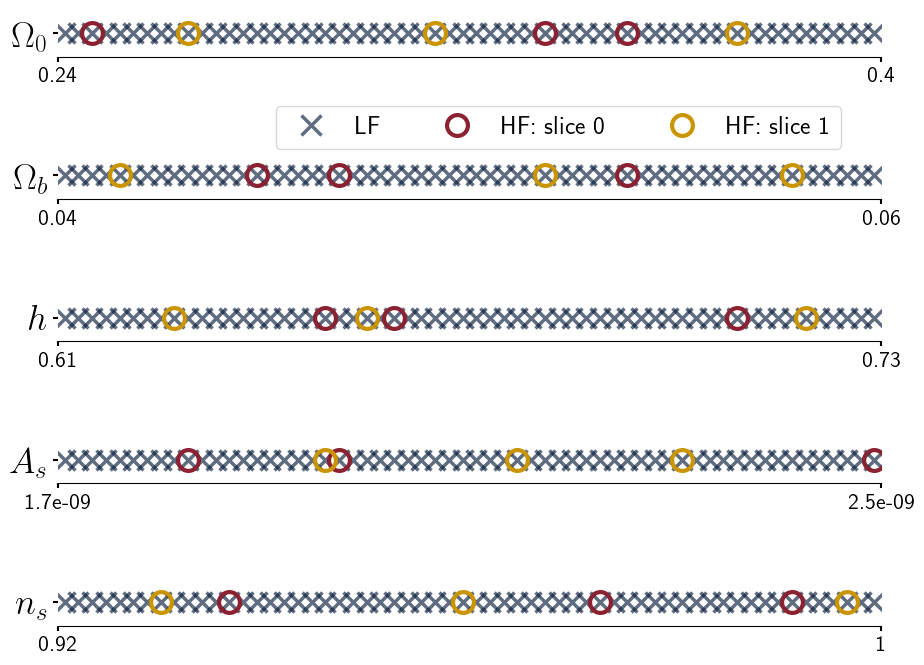

In [9]:
# current emulator setup
fig = plot_samples(
    "data/dmo_60_res128box256/cc_emulator_powerspecs.hdf5",
    "data/dmo_24_res512box256/cc_emulator_powerspecs.hdf5",
)
fig.savefig(
    os.path.join(imgdir, "LHS_samples.pdf"), bbox_inches="tight", pad_inches=0.075
)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


In [5]:
with h5py.File("data/dmo_60_res128box256/cc_emulator_powerspecs.hdf5", "r") as f:
    params = f["params"][()]


In [22]:
plt.style.use("dark_background")

In [40]:
params.T[-3:, :3]


array([[6.27000000e-01, 6.55000000e-01, 7.19000000e-01],
       [2.14666667e-09, 1.96000000e-09, 2.30666667e-09],
       [9.96666667e-01, 9.30000000e-01, 9.59333333e-01]])

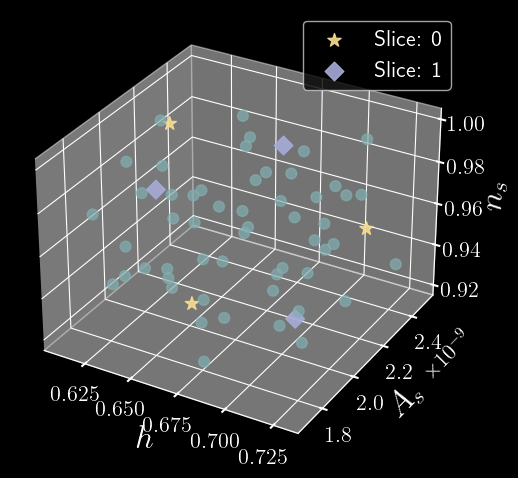

In [38]:
# 3D SLHD plot
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection="3d"))
x, y, z = params.T[-3:, 3:57]
ax.scatter(x, y, z, s=60, color="#82AEB1", alpha=0.7)

# 1st slice
x, y, z = params.T[-3:, :3]
ax.scatter(x, y, z, s=100, marker="*", color="#F5DD90", alpha=0.9, label="Slice: 0")
# 2nd slice
x, y, z = params.T[-3:, -3:]
ax.scatter(x, y, z, s=90, marker="D", color="#A7ACD9", alpha=0.9, label="Slice: 1")


ax.set_xlabel("$h$")
ax.set_ylabel("$A_s$")
ax.set_zlabel("$n_s$")
ax.legend(fontsize=16)
fig.tight_layout()
fig.savefig("slhd_3d.png", format="png", dpi=150)


## Figure 10: Averaged Error per bin


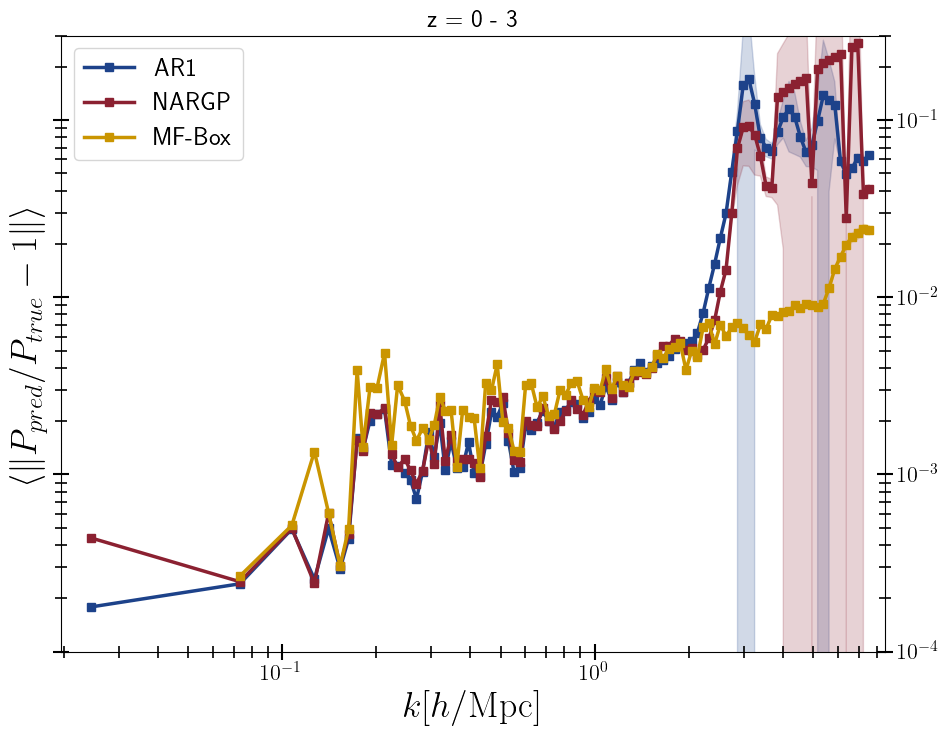

In [14]:
def make_average_all_z_versus_k(
    vloader: ValidationLoader,
    new_fig: bool = False,
    ax=None,
    fig=None,
    color="C0",
    zmin: float = 0.0,
    zmax: float = 3.1,
    **kwargs
):
    if new_fig:
        fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

    # Shape (number of zs, number of test points, number of k bins)

    ## Large scales
    ## Start here
    ## --------------
    z = np.array(vloader.z)
    ind_z = (zmin <= z) & (z < zmax)
    absmeanLF = vloader.relative_errors[ind_z, :, :].mean(axis=(0, 1))
    absstdLF = vloader.relative_errors[ind_z, :, :].std(axis=(0, 1))

    ax.semilogx(10 ** vloader.kf[0], absmeanLF, "s-", lw=2.5, color=color, **kwargs)
    # plot variance instead of std
    ax.fill_between(
        10 ** vloader.kf[0],
        (
            absmeanLF - absstdLF**2
        ),  # TODO: Correct the paper. I am actually showing the variance.
        (absmeanLF + absstdLF**2),
        alpha=0.2,
        color=color,
    )

    return fig, ax


fig, ax = make_average_all_z_versus_k(
    vloaders.ar1_L60_H3_z0_1_2_slice_19,
    new_fig=True,
    color=colors[2],
    label="AR1",
)
fig, ax = make_average_all_z_versus_k(
    vloaders.nargp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[0],
    label="NARGP",
    ax=ax,
    fig=fig,
)

# MFBOX
fig, ax = make_average_all_z_versus_k(
    vloaders.dgmgp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[1],
    label=mf_box,
    ax=ax,
    fig=fig,
)


# Martin style
ax.set_xlabel(r"$k [h/\mathrm{Mpc}]$", fontsize=26)
ax.set_ylabel(r"$\langle\| P_{{pred}}/P_{{true}} - 1 \|\rangle$", fontsize=26)
ax.set_yscale("log")
ax.set_ylim([1e-4, 3e-1])
ax.set_xlim([kf_test.min() * 0.8, kf_test.max() * 1.1])

ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8)

ax.legend()
ax.set_title("z = 0 - 3")

ax.patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join(imgdir, "dgmgp_all_z_versus_k.pdf"),
    bbox_inches="tight",
    pad_inches=0.075,
)
plt.show()

## Figure 11: Break down redshift bins


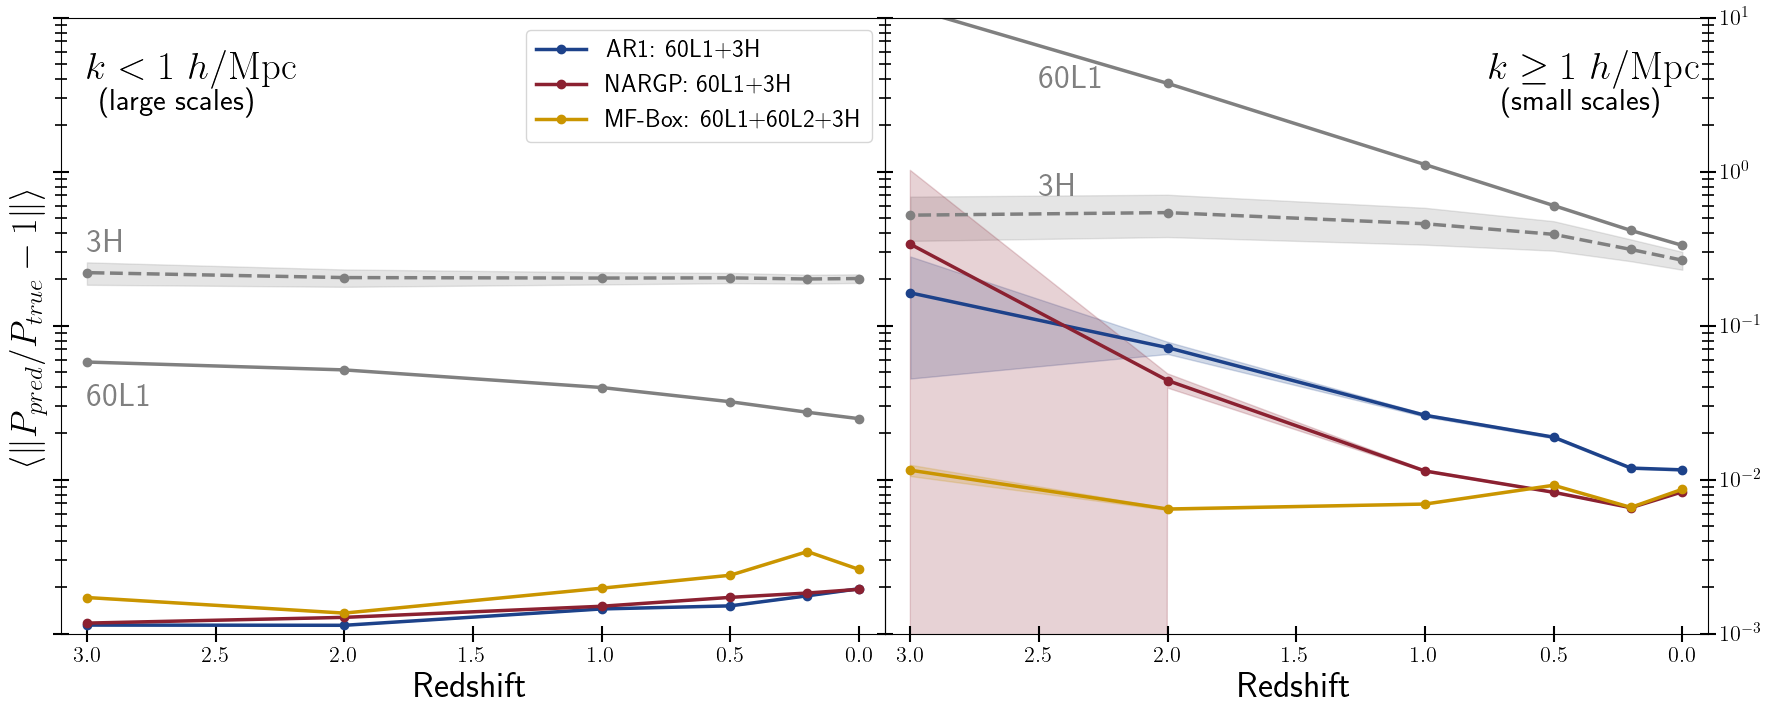

In [16]:
# z versus small and large scale error (all sims) for 40-4, LF and HF only
# L1 error exlcuded because variance is too large due to bias in the tail, which is not fair
fig, ax = plt.subplots(figsize=(2 * 10.625, 8), nrows=1, ncols=2, sharey=True)
plt.setp(ax, ylim=[1e-3, 10], xlim=[3.1, -0.1], yscale="log")

zz = vloaders.ar1_L60_H3_z0_1_2_slice_19.z

k_pivot = 1  # h/Mpc

## Large scales
## Start here
## -------------
##
# Shape (number of redshifts, number of test points, number of k bins)
kf = vloaders.ar1_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf < k_pivot
lfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].mean(
    axis=(1, 2)
)
lfstd = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].std(
    axis=(1, 2)
)

hfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].mean(
    axis=(1, 2)
)
hfstd = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].std(
    axis=(1, 2)
)

absmeanLF = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(
    axis=(1, 2)
)
absstdLF = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(
    axis=(1, 2)
)

absmeanNARGP = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(
    axis=(1, 2)
)
absstdNARGP = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(
    axis=(1, 2)
)

kf = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf < k_pivot
absmeandGMGP = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(
    axis=(1, 2)
)
absstddGMGP = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(
    axis=(1, 2)
)

ax[0].plot(
    zz,
    lfmean,
    "o-",
    c="grey",
    lw=2.5,
)
# ax[0].fill_between(zz, (lfmean-lfstd**2), (lfmean+lfstd**2), color=c_flatirons, alpha=0.4,)

ax[0].plot(
    zz,
    hfmean,
    "o--",
    color="grey",
    lw=2.5,
)
ax[0].fill_between(
    zz, (hfmean - hfstd**2), (hfmean + hfstd**2), color="grey", alpha=0.2
)

ax[0].plot(zz, absmeanLF, "o-", c=colors[2], lw=2.5, label="AR1: 60L1+3H")
ax[0].fill_between(
    zz,
    (absmeanLF - absstdLF**2),
    (absmeanLF + absstdLF**2),
    color=colors[2],
    alpha=0.2,
)

ax[0].plot(zz, absmeanNARGP, "o-", c=colors[0], lw=2.5, label="NARGP: 60L1+3H")
ax[0].fill_between(
    zz,
    (absmeanNARGP - absstdNARGP**2),
    (absmeanNARGP + absstdNARGP**2),
    color=colors[0],
    alpha=0.2,
)

ax[0].plot(zz, absmeandGMGP, "o-", c=colors[1], lw=2.5, label=mf_box + ": 60L1+60L2+3H")
ax[0].fill_between(
    zz,
    (absmeandGMGP - absstddGMGP**2),
    (absmeandGMGP + absstddGMGP**2),
    color=colors[1],
    alpha=0.2,
)


## Small scales
## Start here
## -------------
##
# Shape (number of redshifts, number of test points, number of k bins)
kf = vloaders.ar1_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf >= k_pivot
lfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].mean(
    axis=(1, 2)
)
lfstd = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].std(
    axis=(1, 2)
)

hfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].mean(
    axis=(1, 2)
)
hfstd = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].std(
    axis=(1, 2)
)

absmeanLF = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(
    axis=(1, 2)
)
absstdLF = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(
    axis=(1, 2)
)

absmeanNARGP = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(
    axis=(1, 2)
)
absstdNARGP = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(
    axis=(1, 2)
)

kf = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf >= k_pivot
absmeandGMGP = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(
    axis=(1, 2)
)
absstddGMGP = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(
    axis=(1, 2)
)

ax[1].plot(zz, lfmean, "o-", c="grey", lw=2.5, label="60L1")
# ax[1].fill_between(zz, (lfmean-lfstd**2), (lfmean+lfstd**2), color=c_flatirons, alpha=0.4,)

ax[1].plot(zz, hfmean, "o--", color="grey", lw=2.5, label="3H")
ax[1].fill_between(
    zz, (hfmean - hfstd**2), (hfmean + hfstd**2), color="grey", alpha=0.2
)

ax[1].plot(zz, absmeanLF, "o-", c=colors[2], lw=2.5, label="AR1: 60L1+3H")
ax[1].fill_between(
    zz,
    (absmeanLF - absstdLF**2),
    (absmeanLF + absstdLF**2),
    color=colors[2],
    alpha=0.2,
)

ax[1].plot(zz, absmeanNARGP, "o-", c=colors[0], lw=2.5, label="NARGP: 60L1+3H")
ax[1].fill_between(
    zz,
    (absmeanNARGP - absstdNARGP**2),
    (absmeanNARGP + absstdNARGP**2),
    color=colors[0],
    alpha=0.2,
)

ax[1].plot(zz, absmeandGMGP, "o-", c=colors[1], lw=2.5, label=mf_box + ": 60L1+60L2+3H")
ax[1].fill_between(
    zz,
    (absmeandGMGP - absstddGMGP**2),
    (absmeandGMGP + absstddGMGP**2),
    color=colors[1],
    alpha=0.2,
)

ax[0].text(3, 3e-2, "60L1", c="grey", fontsize=24)
ax[0].text(3, 3e-1, "3H", color="grey", fontsize=24)
# ax[0].text(1, 0.7e-2, 'AR1: 60L1+3H', c=c_midnight, fontsize=24)
# ax[0].fill_between([4.1, 2.6], [3e-3, 3e-3], [3e-1, 3e-1], color=c_skyline, alpha=0.1)
# ax[0].text(3.98, 1.2e-1, r'He II Reionization', c=c_skyline, fontsize=24)
ax[0].text(3.0, 4, "$k < 1$ $h/\mathrm{Mpc}$", color="k", fontsize=28)
ax[0].text(2.95, 2.5, "(large scales)", color="k", fontsize=22)

ax[1].text(2.5, 3.5, "60L1", c="grey", fontsize=24)
ax[1].text(2.5, 7e-1, "3H", color="grey", fontsize=24)
# ax[1].text(3.2, 0.6e-2, '40 LF + 6 HF', c=c_midnight, fontsize=24)
# ax[1].fill_between([4.1, 2.6], [3e-3, 3e-3], [3e-1, 3e-1], color=c_skyline, alpha=0.1)
# ax[1].text(3.98, 1.2e-1, r'He II Reionization', c=c_skyline, fontsize=24)
ax[1].text(0.75, 4, "$k \geq 1$ $h/\mathrm{Mpc}$", color="k", fontsize=28)
ax[1].text(0.70, 2.5, "(small scales)", color="k", fontsize=22)

ax[0].set_xlabel(r"Redshift", fontsize=26)
ax[1].set_xlabel(r"Redshift", fontsize=26)
ax[0].set_ylabel(r"$\langle\| P_{{pred}}/P_{{true}} - 1 \|\rangle$", fontsize=26)

ax[0].tick_params(which="both", direction="inout", labelleft=False, length=12)
ax[0].tick_params(which="minor", length=8)
ax[1].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax[1].tick_params(which="minor", length=8)

ax[0].patch.set_facecolor("none")
ax[1].patch.set_facecolor("none")

ax[0].legend()

fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join(imgdir, "dgmgp_all_k_versus_z_and_scales.pdf"),
    bbox_inches="tight",
    pad_inches=0.075,
)
plt.show()

## Figure 16: Runtime Error


In [17]:
# Get the error including redshifts, [0, 0.2, 0.5, 1, 2]
# LF only
emu_list = [
    vloaders.ar1_H3_slice19,
    vloaders.ar1_H3_slice19_z0_2,
    vloaders.ar1_H3_slice19_z0_5,
    vloaders.ar1_H3_slice19_z1,
    vloaders.ar1_H3_slice19_z2,
    vloaders.ar1_H3_slice19_z3,
]
# shape (redshifts, vary lf, test sims, k bins)
lf_only_error = np.array([emu.relative_errors_lf for emu in emu_list])


# HF only
emu_list = [
    vloaders.ar1_L60_H3_10_z0,
    vloaders.ar1_L60_H3_10_z0_2,
    vloaders.ar1_L60_H3_10_z0_5,
    vloaders.ar1_L60_H3_10_z1,
    vloaders.ar1_L60_H3_10_z2,
    vloaders.ar1_L60_H3_10_z3,
]
# shape (redshifts, vary hf, test sims, k bins)
hf_only_error = np.array([emu.relative_errors_hf for emu in emu_list])


# MF: [Vary LF]-3H
ar1_list = [
    vloaders.ar1_H3_slice19,
    vloaders.ar1_H3_slice19_z0_2,
    vloaders.ar1_H3_slice19_z0_5,
    vloaders.ar1_H3_slice19_z1,
    vloaders.ar1_H3_slice19_z2,
    vloaders.ar1_H3_slice19_z3,
]
nargp_list = [
    vloaders.nargp_H3_slice19,
    vloaders.nargp_H3_slice19_z0_2,
    vloaders.nargp_H3_slice19_z0_5,
    vloaders.nargp_H3_slice19_z1,
    vloaders.nargp_H3_slice19_z2,
    vloaders.nargp_H3_slice19_z3,
]
dgmgp_list = [
    vloaders.dgmgp_H3_slice19,
    vloaders.dgmgp_H3_slice19_z0_2,
    vloaders.dgmgp_H3_slice19_z0_5,
    vloaders.dgmgp_H3_slice19_z1,
    vloaders.dgmgp_H3_slice19_z2,
    vloaders.dgmgp_H3_slice19_z3,
]
# shape (redshifts, vary lf, test sims, k bins)
ar1_vary_lf = np.array([emu.relative_errors for emu in ar1_list])
nargp_vary_lf = np.array([emu.relative_errors for emu in nargp_list])
dgmgp_vary_lf = np.array([emu.relative_errors for emu in dgmgp_list])

# LF2 errors:
# shape (redshifts, vary lf, test sims, k bins)
lf_only_error_2 = np.array([np.abs(emu._pred_exacts_lf_2 - 1) for emu in dgmgp_list])


# MF: 60L-[Vary H]
ar1_list = [
    vloaders.ar1_L60_H3_10_z0,
    vloaders.ar1_L60_H3_10_z0_2,
    vloaders.ar1_L60_H3_10_z0_5,
    vloaders.ar1_L60_H3_10_z1,
    vloaders.ar1_L60_H3_10_z2,
    vloaders.ar1_L60_H3_10_z3,
]
nargp_list = [
    vloaders.nargp_L60_H3_10_z0,
    vloaders.nargp_L60_H3_10_z0_2,
    vloaders.nargp_L60_H3_10_z0_5,
    vloaders.nargp_L60_H3_10_z1,
    vloaders.nargp_L60_H3_10_z2,
    vloaders.nargp_L60_H3_10_z3,
]
dgmgp_list = [
    vloaders.dgmgp_L60_H3_10_z0,
    vloaders.dgmgp_L60_H3_10_z0_2,
    vloaders.dgmgp_L60_H3_10_z0_5,
    vloaders.dgmgp_L60_H3_10_z1,
    vloaders.dgmgp_L60_H3_10_z2,
    vloaders.dgmgp_L60_H3_10_z3,
]
# shape (redshifts, vary hf, test sims, k bins)
ar1_vary_hf = np.array([emu.relative_errors for emu in ar1_list])
nargp_vary_hf = np.array([emu.relative_errors for emu in nargp_list])
dgmgp_vary_hf = np.array([emu.relative_errors for emu in dgmgp_list])

### Figure 16.1: No Inferred error


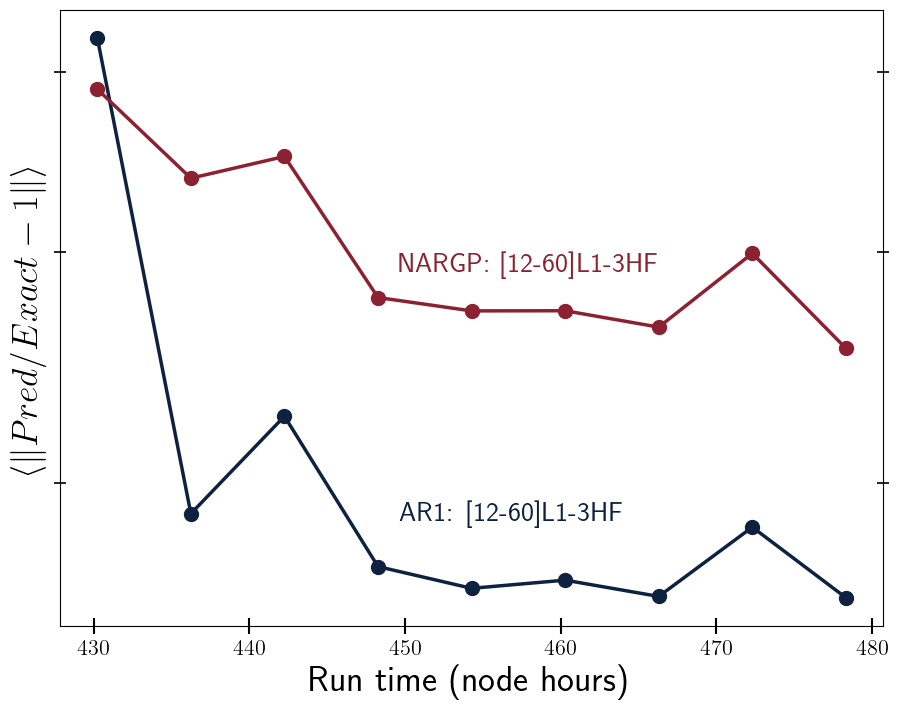

In [18]:
# # optimization times converted to hours -- too subdominant to matter
# times_4hf = np.array([84, 85, 92, 106, 133, 166, 156, 160, 173, 180, 174, 179, 179, 194, 197, 194, 193, 195, 187])/60
# times_3hf = np.array([118, 174, 172, 192])/60
# times_2hf = np.array([92, 178, 193, 202])/60

# LF1: used 8 nodes, MPIs: 16 Threads: 32 Elapsed: 446.128
# [TODO] Currently only a rough estimate
time_per_lfsim = np.mean([446.128, 402.408, 518.769, 436.079]) * 8 / 3600
time_per_hfsim = np.mean([47452.16, 58640.92, 82104.07]) * 8 / 3600

time_per_lfsim2 = np.mean([638.619, 767.55, 953.475, 724.265, 706.971]) * 8 / 3600

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# LF only
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim,
#     lf_only_error.mean(axis=(0, 2, 3)),
#     's-',
#     c=c_skyline,
#     ms=10
# )
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2,
#     lf_only_error_2.mean(axis=(0, 2, 3)),
#     's-',
#     c=c_skyline,
#     ms=10
# )

# HF only
_time_hf_only = (
    np.array(
        [
            3,
            4,
            5,
            6,
            7,
            8,
            9,
            10,
            11,
            # 12, 13, 14, 15, 16, 17 # sbird: only do until 1500 SUs
        ]
    )
    * time_per_hfsim
)
# ax.plot(
#     _time_hf_only,
#     hf_only_error.mean(axis=(0, 2, 3))[:len(_time_hf_only)],
#     's-',
#     c=c_skyline,
#     ms=10
# )
# MF: Vary LF
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + 3 * time_per_hfsim,
    ar1_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_midnight,
    ms=10,
    label="AR1 [12-60]L1-3H",
)
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + 3 * time_per_hfsim,
    nargp_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_flatirons,
    ms=10,
    label="NARGP [12-60]L1-3H",
)
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2 +
#     3 * time_per_hfsim,
#     dgmgp_vary_lf.mean(axis=(0, 2, 3)),
#     'o-',
#     lw=2.5,
#     c=c_sunshine,
#     ms=10,
#     label=mf_box + " [12-60]L1-[12-60]L2-3H",
# )

# Texts
# ax.text(
#     1.5 * 60 * time_per_lfsim,
#     0.85*lf_only_error.mean(axis=(0, 2, 3))[-1],
#     '[12-60] L1',
#     fontsize=20,
#     color=c_skyline,
# )
# ax.text(
#     1.5 * 60 * time_per_lfsim2,
#     0.85*lf_only_error_2.mean(axis=(0, 2, 3))[-1],
#     '[12-60] L2',
#     fontsize=20,
#     color=c_skyline,
# )
# ax.text(
#     1.05 * _time_hf_only[-1],
#     0.85*hf_only_error.mean(axis=(0, 2, 3))[:len(_time_hf_only)][-1],
#     '[3-11] HF', # sbird only count until 1500 SUs
#     fontsize=20,
#     color=c_skyline,
# )
ax.text(
    0.94 * (3 * time_per_hfsim + 60 * time_per_lfsim),
    1.1 * ar1_vary_lf.mean(axis=(0, 2, 3))[-1],
    "AR1: [12-60]L1-3HF",
    fontsize=20,
    color=c_midnight,
)
ax.text(
    0.94 * (3 * time_per_hfsim + 60 * time_per_lfsim),
    1.1 * nargp_vary_lf.mean(axis=(0, 2, 3))[-1],
    "NARGP: [12-60]L1-3HF",
    fontsize=20,
    color=c_flatirons,
)
# ax.text(
#     1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim + 60 * time_per_lfsim2),
#     0.85*dgmgp_vary_lf.mean(axis=(0, 2, 3))[-1],
#     mf_box + ': [12-60](L1,L2)-3HF',
#     fontsize=20,
#     color=c_sunshine,
# )

ax.set_xlabel("Run time (node hours)", fontsize=26)
ax.set_ylabel(r"$\langle\| Pred/Exact - 1 \|\rangle$", fontsize=26)
ax.set_yscale("log")
# ax.set_xscale('log')

# ax.set_ylim([7e-3, 1e-1])
# ax.set_xlim([0, 2000])

ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8, labelright=False, labelleft=False)

fig.patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join(imgdir, "runtime_error_zoomed_AR1_NARGP.pdf"),
    bbox_inches="tight",
    pad_inches=0.075,
)
plt.show()

### Figure 16.2: Inferred errors for HF and MF


In [10]:
# shape (redshifts, vary hf, test sims, k bins)
_discard = 2

_hf_errors_per_hf_per_test = hf_only_error.mean(axis=(0, 3))
_y_train = _hf_errors_per_hf_per_test.mean(axis=1)[_discard:]
_y_sigma = _hf_errors_per_hf_per_test.std(axis=1)[_discard:]

d = 5
RANDOM_SEED = 713

_x_train = np.array(
    [
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,  # sbird: only do until 1500 SUs
    ]
)[_discard:]

with pm.Model() as _hf_only_model:
    theta = pm.LogNormal("theta", mu=0, sigma=1)

    # InverseGamma has nice properties:
    # it's continuous and has support x ∈ (0, inf)
    nu1 = pm.LogNormal("nu1", 0, 1)

    y = theta * (_x_train ** (-nu1 / d))

    pm.Normal("likelihood", mu=y, sigma=_y_sigma, observed=_y_train)

    start = {
        "theta": _y_train.mean(),
        "nu1": 6,
    }
    trace = pm.sample(10000, tune=35000, initvals=start, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, nu1]


Sampling 4 chains for 35_000 tune and 10_000 draw iterations (140_000 + 40_000 draws total) took 27 seconds.


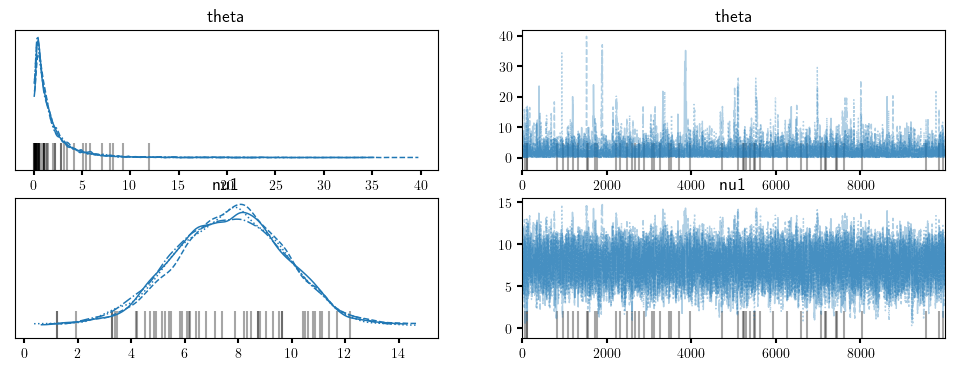

In [11]:
with _hf_only_model:
    rvs = [
        "theta",
        "nu1",
    ]

    _ = az.plot_trace(
        trace,
        var_names=rvs,
    )

In [12]:
# Get HF only the posteriors
_, _theta_median, _ = np.quantile(trace.posterior["theta"], [0.25, 0.5, 0.75])
_, _nu1_median, _ = np.quantile(trace.posterior["nu1"], [0.25, 0.5, 0.75])

n_hf = np.linspace(2, 20)


def budget_size_hf_only_fn(num_hf, theta, nu1, d=5):
    return theta * (num_hf ** (-nu1 / d))


y_pred_hf = budget_size_hf_only_fn(n_hf, _theta_median, _nu1_median, d=5)

In [13]:
# loading the GMGP infferred error trace
trace_gmgp = az.from_json("budget_size/mcmc_samples/samples_dgmgp.json")


In [14]:
def get_quantiles(trace):
    # Finding the quantiles
    theta_lower, theta_median, theta_upper = np.quantile(
        trace.posterior["theta"], [0.25, 0.5, 0.75]
    )
    rho1_lower, rho1_median, rho1_upper = np.quantile(
        trace.posterior["rho1"], [0.25, 0.5, 0.75]
    )
    rho2_lower, rho2_median, rho2_upper = np.quantile(
        trace.posterior["rho2"], [0.25, 0.5, 0.75]
    )
    nu1_lower, nu1_median, nu1_upper = np.quantile(
        trace.posterior["nu1"], [0.25, 0.5, 0.75]
    )
    nu2_lower, nu2_median, nu2_upper = np.quantile(
        trace.posterior["nu2"], [0.25, 0.5, 0.75]
    )
    nu0_lower, nu0_median, nu0_upper = np.quantile(
        trace.posterior["nu0"], [0.25, 0.5, 0.75]
    )

    return (
        rho1_median,
        rho2_median,
        theta_median,
        nu1_median,
        nu2_median,
        nu0_median,
        rho1_upper,
        rho2_upper,
        theta_upper,
        nu1_upper,
        nu2_upper,
        nu0_upper,
        rho1_lower,
        rho2_lower,
        theta_lower,
        nu1_lower,
        nu2_lower,
        nu0_lower,
    )


def budget_size_fn_l1_l2(num_l1, num_l2, num_hf, theta, rho1, rho2, nu1, nu2, nu0, d=5):
    """This is to include both L1 and L2 numbers"""
    return theta * (
        rho1 * num_l1 ** (-nu1 / d) + rho2 * num_l2 ** (-nu2 / d) + num_hf ** (-nu0 / d)
    )


(
    rho1_median,
    rho2_median,
    theta_median,
    nu1_median,
    nu2_median,
    nu0_median,
    rho1_upper,
    rho2_upper,
    theta_upper,
    nu1_upper,
    nu2_upper,
    nu0_upper,
    rho1_lower,
    rho2_lower,
    theta_lower,
    nu1_lower,
    nu2_lower,
    nu0_lower,
) = get_quantiles(trace_gmgp)


n_l1 = np.linspace(2, 800)
n_l2 = np.linspace(2, 800)

# predictions
y_pred_gmgp_xlf_3hf = budget_size_fn_l1_l2(
    n_l1,
    n_l2,
    3,
    theta_median,
    rho1_median,
    rho2_median,
    nu1_median,
    nu2_median,
    nu0_median,
    d=5,
)


# optimal
def n_l_estimated(
    n_h: int,
    cost_l: float,
    cost_h: float,
    rho: float,
    nu_l: float,
    nu_h: float,
) -> float:
    _n_h_power_law = n_h ** (-(nu_h + d) / d)

    _cost_ratio = cost_l / cost_h

    _temp = nu_h / (rho * nu_h)

    _temp = _n_h_power_law * _cost_ratio * _temp

    _de_n_l_power_law = (_temp) ** (-d / (nu_l + d))
    return _de_n_l_power_law


_n_hf = np.linspace(2, 10)

# Error(num of HFs)
_n_l1 = n_l_estimated(
    n_h=_n_hf,
    cost_l=1,
    cost_h=140,
    rho=rho1_median,
    nu_l=nu1_median,
    nu_h=nu0_median,
)
_n_l2 = n_l_estimated(
    n_h=_n_hf,
    cost_l=1.7,
    cost_h=140,
    rho=rho2_median,
    nu_l=nu2_median,
    nu_h=nu0_median,
)

_y_pred_hf = budget_size_fn_l1_l2(
    _n_l1,
    _n_l2,
    _n_hf,
    theta_median,
    rho1_median,
    rho2_median,
    nu1_median,
    nu2_median,
    nu0_median,
)

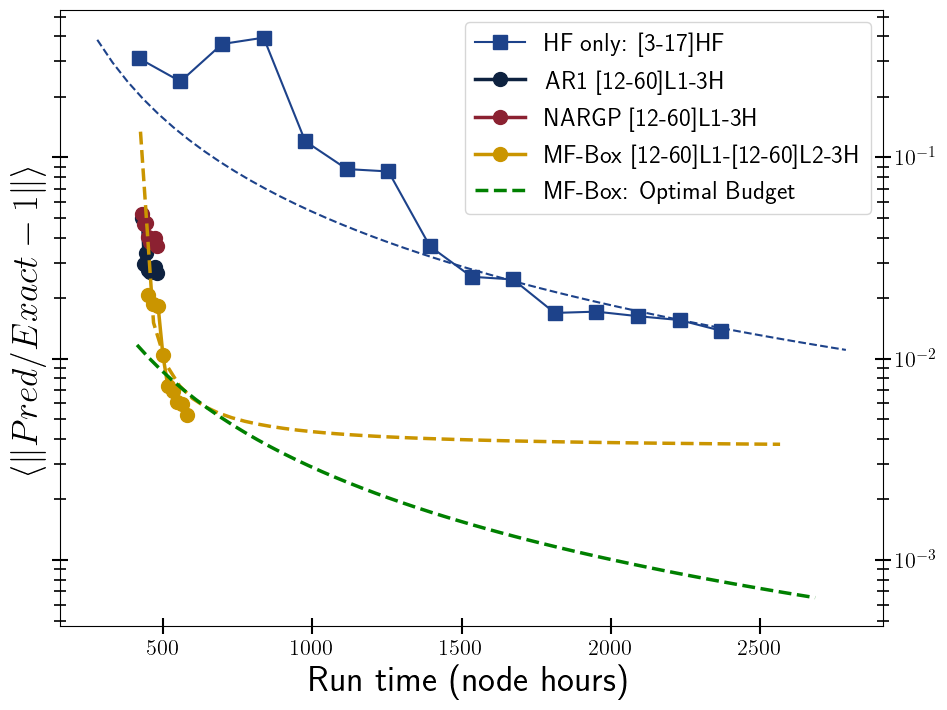

In [19]:
# 2/3: Include the inference results

# # optimization times converted to hours -- too subdominant to matter
# times_4hf = np.array([84, 85, 92, 106, 133, 166, 156, 160, 173, 180, 174, 179, 179, 194, 197, 194, 193, 195, 187])/60
# times_3hf = np.array([118, 174, 172, 192])/60
# times_2hf = np.array([92, 178, 193, 202])/60

# LF1: used 8 nodes, MPIs: 16 Threads: 32 Elapsed: 446.128
# [TODO] Currently only a rough estimate
time_per_lfsim = np.mean([446.128, 402.408, 518.769, 436.079]) * 8 / 3600
time_per_hfsim = np.mean([47452.16, 58640.92, 82104.07]) * 8 / 3600

time_per_lfsim2 = np.mean([638.619, 767.55, 953.475, 724.265, 706.971]) * 8 / 3600

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# LF only
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim,
#     lf_only_error.mean(axis=(0, 2, 3)),
#     's-',
#     c=c_skyline,
#     ms=10
# )
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2,
#     lf_only_error_2.mean(axis=(0, 2, 3)),
#     's-',
#     c=c_skyline,
#     ms=10
# )

# HF only
_time_hf_only = (
    np.array(
        [
            3,
            4,
            5,
            6,
            7,
            8,
            9,
            10,
            11,
            12,
            13,
            14,
            15,
            16,
            17,  # sbird: only do until 1500 SUs
        ]
    )
    * time_per_hfsim
)
ax.plot(
    _time_hf_only,
    hf_only_error.mean(axis=(0, 2, 3))[: len(_time_hf_only)],
    "s-",
    c=c_skyline,
    ms=10,
    label="HF only: [3-17]HF",
)
# MF: Vary LF
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + 3 * time_per_hfsim,
    ar1_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_midnight,
    ms=10,
    label="AR1 [12-60]L1-3H",
)
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + 3 * time_per_hfsim,
    nargp_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_flatirons,
    ms=10,
    label="NARGP [12-60]L1-3H",
)
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2
    + 3 * time_per_hfsim,
    dgmgp_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_sunshine,
    ms=10,
    label=mf_box + " [12-60]L1-[12-60]L2-3H",
)

# Texts
# ax.text(
#     1.5 * 60 * time_per_lfsim,
#     0.85*lf_only_error.mean(axis=(0, 2, 3))[-1],
#     '[12-60] L1',
#     fontsize=20,
#     color=c_skyline,
# )
# ax.text(
#     1.5 * 60 * time_per_lfsim2,
#     0.85*lf_only_error_2.mean(axis=(0, 2, 3))[-1],
#     '[12-60] L2',
#     fontsize=20,
#     color=c_skyline,
# )
# ax.text(
#     1.05 * _time_hf_only[-1],
#     0.85*hf_only_error.mean(axis=(0, 2, 3))[:len(_time_hf_only)][-1],
#     '[3-11] HF', # sbird only count until 1500 SUs
#     fontsize=20,
#     color=c_skyline,
# )
# ax.text(
#     1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
#     0.85*ar1_vary_lf.mean(axis=(0, 2, 3))[-1],
#     'AR1: [12-60]L1-3HF',
#     fontsize=20,
#     color=c_midnight,
# )
# ax.text(
#     1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
#     0.85*nargp_vary_lf.mean(axis=(0, 2, 3))[-1],
#     'NARGP: [12-60]L1-3HF',
#     fontsize=20,
#     color=c_flatirons,
# )
# ax.text(
#     1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim + 60 * time_per_lfsim2),
#     0.85*dgmgp_vary_lf.mean(axis=(0, 2, 3))[-1],
#     mf_box + ': [12-60](L1,L2)-3HF',
#     fontsize=20,
#     color=c_sunshine,
# )


############ Inference ###############
# HF only
ax.plot(
    n_hf * time_per_hfsim,
    y_pred_hf,
    ls="--",
    c=c_skyline,
    ms=10,
    # label="HF only [{:.0f}-{:.0f}]HF".format(n_hf.min(), n_hf.max())
)
# GMGP fixed 3 HF
ax.plot(
    n_l1 * time_per_lfsim + n_l2 * time_per_lfsim2 + 3 * time_per_hfsim,
    y_pred_gmgp_xlf_3hf,
    ls="--",
    lw=2.5,
    c=c_sunshine,
    ms=10,
    # label="[{:.0f}-{:.0f}](L1,L2)-3HF".format(n_l1.min(), n_l1.max())
)
# GMGP optimal
ax.plot(
    _n_l1 * time_per_lfsim + _n_l2 * time_per_lfsim2 + _n_hf * time_per_hfsim,
    _y_pred_hf,
    ls="--",
    lw=2.5,
    c="green",
    ms=10,
    label="MF-Box: Optimal Budget",
)


ax.set_xlabel("Run time (node hours)", fontsize=26)
ax.set_ylabel(r"$\langle\| Pred/Exact - 1 \|\rangle$", fontsize=26)
ax.set_yscale("log")
# ax.set_xscale('log')

# ax.set_ylim([7e-3, 1e-1])
# ax.set_xlim([250, 3000])

ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8, labelright=False, labelleft=False)

ax.legend()

fig.patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join(imgdir, "runtime_error_with_inference.pdf"),
    bbox_inches="tight",
    pad_inches=0.075,
)
plt.show()

Poster version


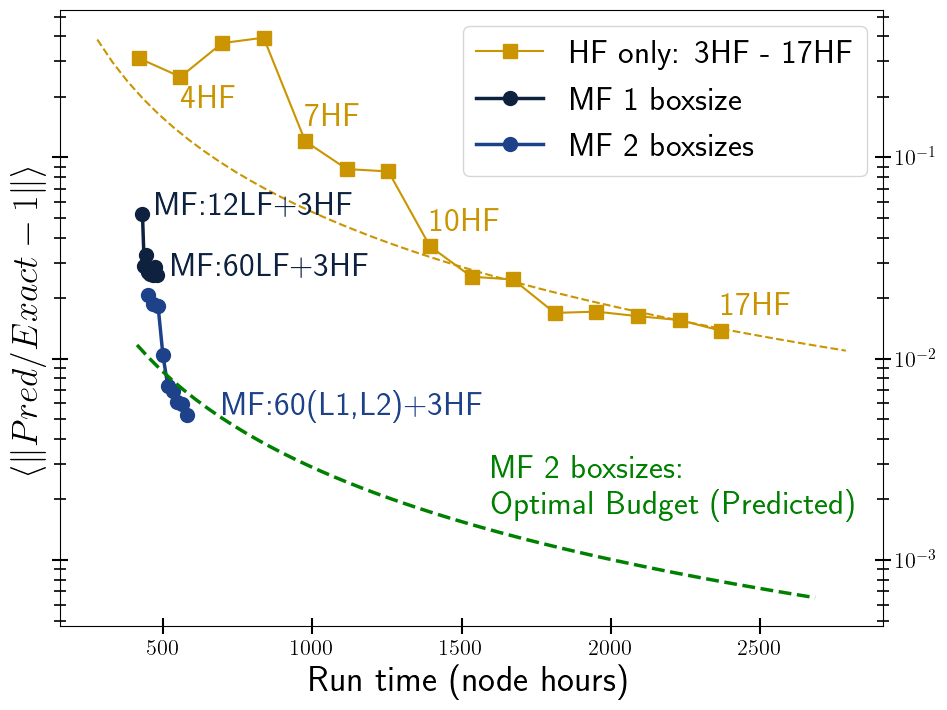

In [46]:
# 2/3: Include the inference results
fontsize = 24

# # optimization times converted to hours -- too subdominant to matter
# times_4hf = np.array([84, 85, 92, 106, 133, 166, 156, 160, 173, 180, 174, 179, 179, 194, 197, 194, 193, 195, 187])/60
# times_3hf = np.array([118, 174, 172, 192])/60
# times_2hf = np.array([92, 178, 193, 202])/60

# LF1: used 8 nodes, MPIs: 16 Threads: 32 Elapsed: 446.128
# [TODO] Currently only a rough estimate
time_per_lfsim = np.mean([446.128, 402.408, 518.769, 436.079]) * 8 / 3600
time_per_hfsim = np.mean([47452.16, 58640.92, 82104.07]) * 8 / 3600

time_per_lfsim2 = np.mean([638.619, 767.55, 953.475, 724.265, 706.971]) * 8 / 3600

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# LF only
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim,
#     lf_only_error.mean(axis=(0, 2, 3)),
#     's-',
#     c=c_skyline,
#     ms=10
# )
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2,
#     lf_only_error_2.mean(axis=(0, 2, 3)),
#     's-',
#     c=c_skyline,
#     ms=10
# )

# HF only
_time_hf_only = (
    np.array(
        [
            3,
            4,
            5,
            6,
            7,
            8,
            9,
            10,
            11,
            12,
            13,
            14,
            15,
            16,
            17,  # sbird: only do until 1500 SUs
        ]
    )
    * time_per_hfsim
)
ax.plot(
    _time_hf_only,
    hf_only_error.mean(axis=(0, 2, 3))[: len(_time_hf_only)],
    "s-",
    c=c_sunshine,
    ms=10,
    label="HF only: 3HF - 17HF",
)
#### HF texts ####
ax.text(
    _time_hf_only[1],
    hf_only_error.mean(axis=(0, 2, 3))[: len(_time_hf_only)][1] * 0.7,
    "4HF",
    c=c_sunshine,
    fontdict={"fontsize": fontsize},
)
ax.text(
    _time_hf_only[4],
    hf_only_error.mean(axis=(0, 2, 3))[: len(_time_hf_only)][4] * 1.2,
    "7HF",
    c=c_sunshine,
    fontdict={"fontsize": fontsize},
)
ax.text(
    _time_hf_only[7],
    hf_only_error.mean(axis=(0, 2, 3))[: len(_time_hf_only)][7] * 1.2,
    "10HF",
    c=c_sunshine,
    fontdict={"fontsize": fontsize},
)
ax.text(
    _time_hf_only[-1],
    hf_only_error.mean(axis=(0, 2, 3))[: len(_time_hf_only)][-1] * 1.2,
    "17HF",
    c=c_sunshine,
    fontdict={"fontsize": fontsize},
)
#### HF texts ####
# MF: Vary LF
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + 3 * time_per_hfsim,
    ar1_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_midnight,
    ms=10,
    label="MF 1 boxsize",
)
#### MF texts ####
ax.text(
    (12 * time_per_lfsim + 3 * time_per_hfsim) * 1.1,
    ar1_vary_lf.mean(axis=(0, 2, 3))[0],
    "MF:12LF+3HF",
    color=c_midnight,
    fontdict={"fontsize": fontsize},
)
ax.text(
    (60 * time_per_lfsim + 3 * time_per_hfsim) * 1.1,
    ar1_vary_lf.mean(axis=(0, 2, 3))[-1],
    "MF:60LF+3HF",
    color=c_midnight,
    fontdict={"fontsize": fontsize},
)

#### MF texts ####
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2
    + 3 * time_per_hfsim,
    dgmgp_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_skyline,
    ms=10,
    label="MF 2 boxsizes",
)
#### MF texts ####
ax.text(
    (60 * time_per_lfsim + 60 * time_per_lfsim2 + 3 * time_per_hfsim) * 1.2,
    dgmgp_vary_lf.mean(axis=(0, 2, 3))[-1],
    "MF:60(L1,L2)+3HF",
    color=c_skyline,
    fontdict={"fontsize": fontsize},
)
# ax.text(
#     (30 * time_per_lfsim +
#     30 * time_per_lfsim2 +
#     3 * time_per_hfsim) * 1.1,
#     dgmgp_vary_lf.mean(axis=(0, 2, 3))[3],
#     "MF:36(L1,L2)+3HF",
#     color=c_skyline,
#     fontdict={"fontsize" : fontsize}
# )


############ Inference ###############
# HF only
ax.plot(
    n_hf * time_per_hfsim,
    y_pred_hf,
    ls="--",
    c=c_sunshine,
    ms=10,
    # label="HF only [{:.0f}-{:.0f}]HF".format(n_hf.min(), n_hf.max())
)
# GMGP optimal
ax.plot(
    _n_l1 * time_per_lfsim + _n_l2 * time_per_lfsim2 + _n_hf * time_per_hfsim,
    _y_pred_hf,
    ls="--",
    lw=2.5,
    c="green",
    ms=10,
    # label="MF 2 boxsizes: Optimal Budget (Predicted)"
)
ax.text(
    2000 - 400,
    1.7e-3,
    "MF 2 boxsizes:\nOptimal Budget (Predicted)",
    color="green",
    fontdict={"fontsize": fontsize},
)


ax.set_xlabel("Run time (node hours)", fontsize=26)
ax.set_ylabel(r"$\langle\| Pred/Exact - 1 \|\rangle$", fontsize=26)
ax.set_yscale("log")
# ax.set_xscale('log')

# ax.set_ylim([7e-3, 1e-1])
# ax.set_xlim([250, 3000])

ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8, labelright=False, labelleft=False)

ax.legend(fontsize=fontsize)

fig.patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig(
#     os.path.join(imgdir, "runtime_error_with_inference.pdf"),
#     bbox_inches='tight', pad_inches=0.075
# )
plt.show()

## Figure 12: Error as Number of LF


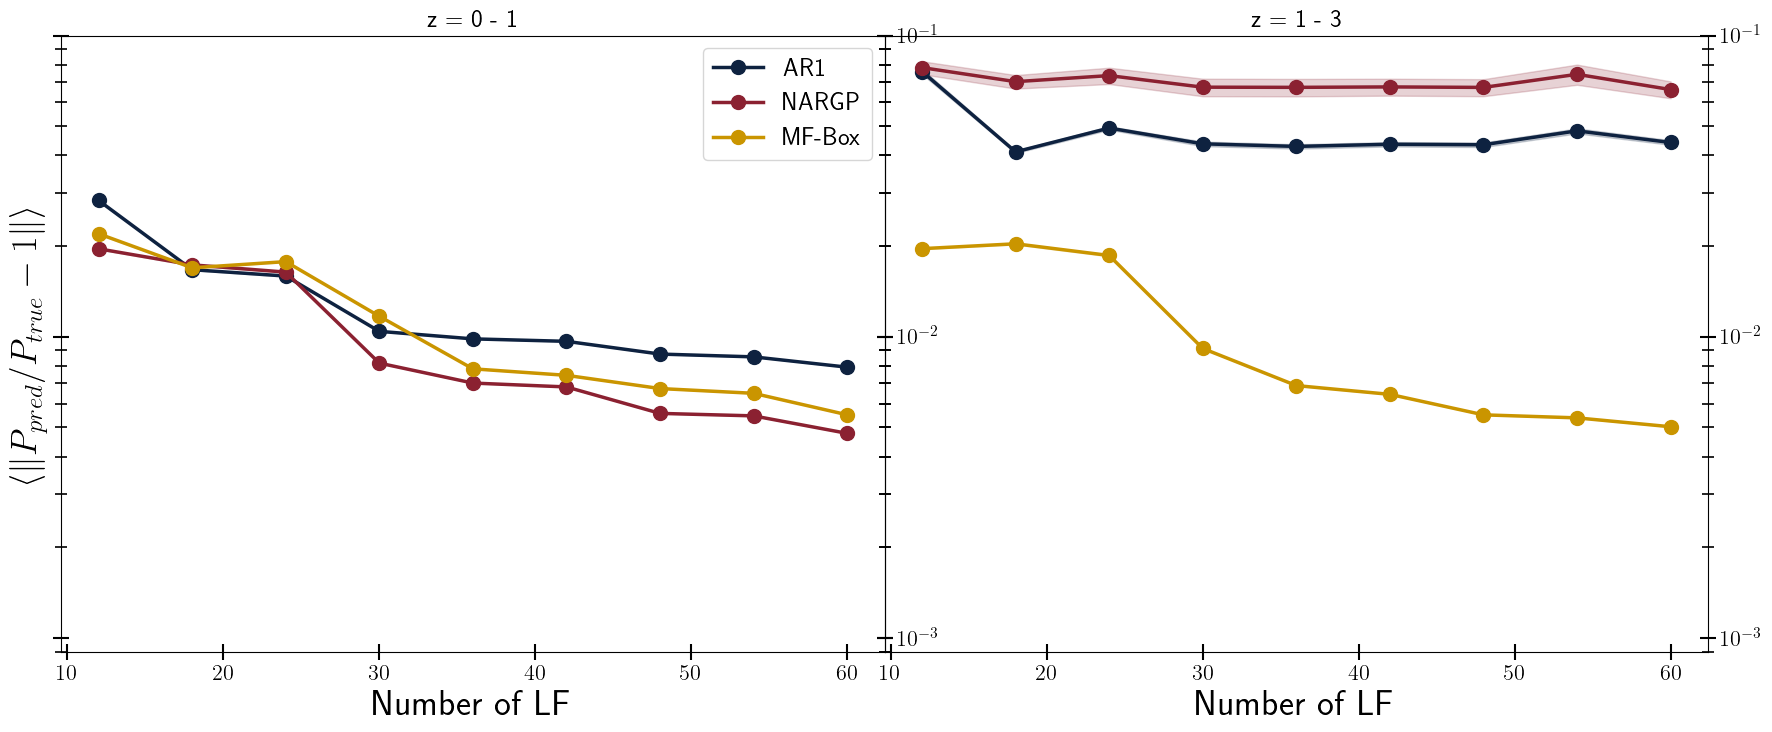

In [30]:
fig, axs = plt.subplots(figsize=(2 * 10.625, 8), nrows=1, ncols=2, sharey=True)

number_lf = vloaders.ar1_H3_slice19.num_lf

# zz = np.array([0, 0.2, 0.5, 1, 2, 3])

# num_hf versus error
# shape (redshifts, vary lf, test sims, k bins)
_ar1_error_per_lf_per_test_low_z = ar1_vary_lf[:3, :, :, :].mean(axis=(0, 3))
_ar1_mean_low_z = _ar1_error_per_lf_per_test_low_z.mean(axis=1)
_ar1_std_low_z = _ar1_error_per_lf_per_test_low_z.std(axis=1)
axs[0].plot(
    number_lf,
    _ar1_mean_low_z,
    "o-",
    lw=2.5,
    ms=10,
    color=c_midnight,
    label="AR1",
)
axs[0].fill_between(
    number_lf,
    _ar1_mean_low_z - _ar1_std_low_z**2,
    _ar1_mean_low_z + _ar1_std_low_z**2,
    color=c_midnight,
    alpha=0.2,
)

_nargp_error_per_lf_per_test_low_z = nargp_vary_lf[:3, :, :, :].mean(axis=(0, 3))
_nargp_mean_low_z = _nargp_error_per_lf_per_test_low_z.mean(axis=1)
_nargp_std_low_z = _nargp_error_per_lf_per_test_low_z.std(axis=1)
axs[0].plot(
    number_lf, _nargp_mean_low_z, "o-", lw=2.5, ms=10, color=c_flatirons, label="NARGP"
)
axs[0].fill_between(
    number_lf,
    _nargp_mean_low_z - _nargp_std_low_z**2,
    _nargp_mean_low_z + _nargp_std_low_z**2,
    color=c_flatirons,
    alpha=0.2,
)

_dgmgp_error_per_lf_per_test_low_z = dgmgp_vary_lf[:3, :, :, :].mean(axis=(0, 3))
_dgmgp_mean_low_z = _dgmgp_error_per_lf_per_test_low_z.mean(axis=1)
_dgmgp_std_low_z = _dgmgp_error_per_lf_per_test_low_z.std(axis=1)
axs[0].plot(
    number_lf, _dgmgp_mean_low_z, "o-", lw=2.5, ms=10, color=c_sunshine, label=mf_box
)
axs[0].fill_between(
    number_lf,
    _dgmgp_mean_low_z - _dgmgp_std_low_z**2,
    _dgmgp_mean_low_z + _dgmgp_std_low_z**2,
    color=c_sunshine,
    alpha=0.2,
)

# Right panel
_ar1_error_per_lf_per_test_high_z = ar1_vary_lf[3:, :, :, :].mean(axis=(0, 3))
_ar1_mean_high_z = _ar1_error_per_lf_per_test_high_z.mean(axis=1)
_ar1_std_high_z = _ar1_error_per_lf_per_test_high_z.std(axis=1)
axs[1].plot(
    number_lf,
    _ar1_mean_high_z,
    "o-",
    lw=2.5,
    ms=10,
    color=c_midnight,
)
axs[1].fill_between(
    number_lf,
    _ar1_mean_high_z - _ar1_std_high_z**2,
    _ar1_mean_high_z + _ar1_std_high_z**2,
    color=c_midnight,
    alpha=0.2,
)

_nargp_error_per_lf_per_test_high_z = nargp_vary_lf[3:, :, :, :].mean(axis=(0, 3))
_nargp_mean_high_z = _nargp_error_per_lf_per_test_high_z.mean(axis=1)
_nargp_std_high_z = _nargp_error_per_lf_per_test_high_z.std(axis=1)
axs[1].plot(
    number_lf,
    _nargp_mean_high_z,
    "o-",
    lw=2.5,
    ms=10,
    color=c_flatirons,
)
axs[1].fill_between(
    number_lf,
    _nargp_mean_high_z - _nargp_std_high_z**2,
    _nargp_mean_high_z + _nargp_std_high_z**2,
    color=c_flatirons,
    alpha=0.2,
)

_dgmgp_error_per_lf_per_test_high_z = dgmgp_vary_lf[3:, :, :, :].mean(axis=(0, 3))
_dgmgp_mean_high_z = _dgmgp_error_per_lf_per_test_high_z.mean(axis=1)
_dgmgp_std_high_z = _dgmgp_error_per_lf_per_test_high_z.std(axis=1)
axs[1].plot(
    number_lf,
    _dgmgp_mean_high_z,
    "o-",
    lw=2.5,
    ms=10,
    color=c_sunshine,
)
axs[1].fill_between(
    number_lf,
    _dgmgp_mean_high_z - _dgmgp_std_high_z**2,
    _dgmgp_mean_high_z + _dgmgp_std_high_z**2,
    color=c_sunshine,
    alpha=0.2,
)


axs[0].set_xlabel("Number of LF", fontsize=26)
axs[0].set_ylabel(r"$\langle\| P_{{pred}}/P_{{true}} - 1 \|\rangle$", fontsize=26)
axs[0].set_yscale("log")
axs[0].set_ylim([3e-4, 1e-1])

axs[1].set_xlabel("Number of LF", fontsize=26)
# axs[1].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
axs[1].set_yscale("log")
axs[1].set_ylim([9e-4, 1e-1])

axs[0].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
axs[0].tick_params(which="minor", length=8)

axs[1].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
axs[1].tick_params(which="minor", length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor("none")
axs[1].patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(os.path.join(imgdir, "vary_lf.pdf"), bbox_inches="tight", pad_inches=0.075)
plt.show()

## Figure 13: Error as function of HF


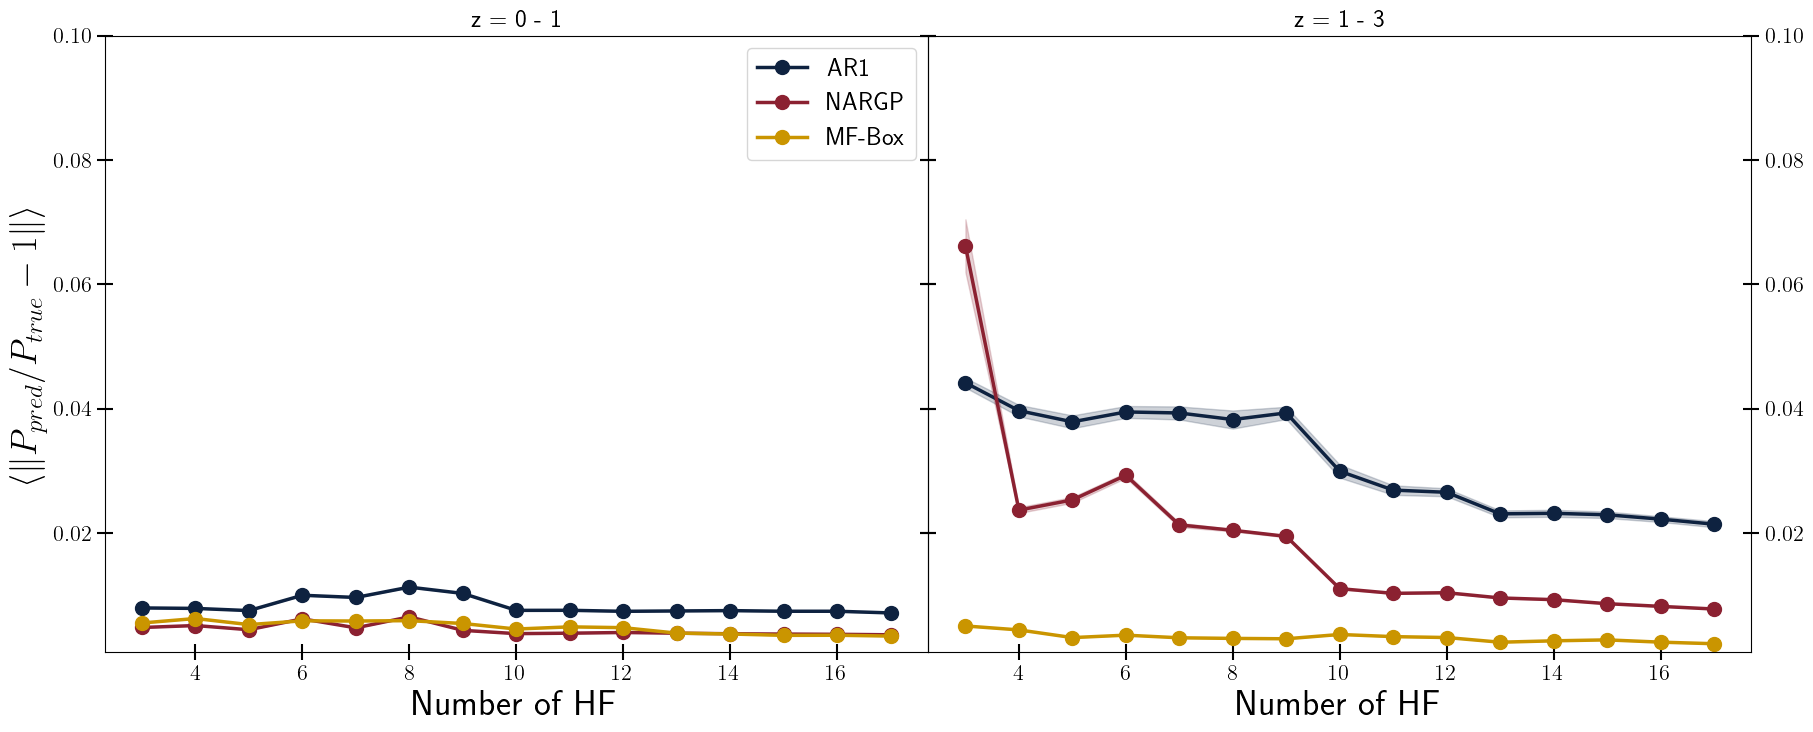

In [28]:
fig, axs = plt.subplots(figsize=(2 * 10.625, 8), nrows=1, ncols=2, sharey=True)

number_hf = vloaders.dgmgp_L60_H3_10_z0.num_hf

# zz = np.array([0, 0.2, 0.5, 1, 2, 3])

# num_hf versus error
# shape (redshifts, vary lf, test sims, k bins)
_ar1_error_per_hf_per_test_low_z = ar1_vary_hf[:3, :, :, :].mean(axis=(0, 3))
_ar1_mean_low_z = _ar1_error_per_hf_per_test_low_z.mean(axis=1)
_ar1_std_low_z = _ar1_error_per_hf_per_test_low_z.std(axis=1)
axs[0].plot(
    number_hf,
    _ar1_mean_low_z,
    "o-",
    lw=2.5,
    ms=10,
    color=c_midnight,
    label="AR1",
)
axs[0].fill_between(
    number_hf,
    _ar1_mean_low_z - _ar1_std_low_z**2,
    _ar1_mean_low_z + _ar1_std_low_z**2,
    color=c_midnight,
    alpha=0.2,
)

_nargp_error_per_hf_per_test_low_z = nargp_vary_hf[:3, :, :, :].mean(axis=(0, 3))
_nargp_mean_low_z = _nargp_error_per_hf_per_test_low_z.mean(axis=1)
_nargp_std_low_z = _nargp_error_per_hf_per_test_low_z.std(axis=1)
axs[0].plot(
    number_hf, _nargp_mean_low_z, "o-", lw=2.5, ms=10, color=c_flatirons, label="NARGP"
)
axs[0].fill_between(
    number_hf,
    _nargp_mean_low_z - _nargp_std_low_z**2,
    _nargp_mean_low_z + _nargp_std_low_z**2,
    color=c_flatirons,
    alpha=0.2,
)

_dgmgp_error_per_hf_per_test_low_z = dgmgp_vary_hf[:3, :, :, :].mean(axis=(0, 3))
_dgmgp_mean_low_z = _dgmgp_error_per_hf_per_test_low_z.mean(axis=1)
_dgmgp_std_low_z = _dgmgp_error_per_hf_per_test_low_z.std(axis=1)
axs[0].plot(
    number_hf, _dgmgp_mean_low_z, "o-", lw=2.5, ms=10, color=c_sunshine, label=mf_box
)
axs[0].fill_between(
    number_hf,
    _dgmgp_mean_low_z - _dgmgp_std_low_z**2,
    _dgmgp_mean_low_z + _dgmgp_std_low_z**2,
    color=c_sunshine,
    alpha=0.2,
)

# Right panel
_ar1_error_per_hf_per_test_high_z = ar1_vary_hf[3:, :, :, :].mean(axis=(0, 3))
_ar1_mean_high_z = _ar1_error_per_hf_per_test_high_z.mean(axis=1)
_ar1_std_high_z = _ar1_error_per_hf_per_test_high_z.std(axis=1)
axs[1].plot(
    number_hf,
    _ar1_mean_high_z,
    "o-",
    lw=2.5,
    ms=10,
    color=c_midnight,
)
axs[1].fill_between(
    number_hf,
    _ar1_mean_high_z - _ar1_std_high_z**2,
    _ar1_mean_high_z + _ar1_std_high_z**2,
    color=c_midnight,
    alpha=0.2,
)

_nargp_error_per_hf_per_test_high_z = nargp_vary_hf[3:, :, :, :].mean(axis=(0, 3))
_nargp_mean_high_z = _nargp_error_per_hf_per_test_high_z.mean(axis=1)
_nargp_std_high_z = _nargp_error_per_hf_per_test_high_z.std(axis=1)
axs[1].plot(
    number_hf,
    _nargp_mean_high_z,
    "o-",
    lw=2.5,
    ms=10,
    color=c_flatirons,
)
axs[1].fill_between(
    number_hf,
    _nargp_mean_high_z - _nargp_std_high_z**2,
    _nargp_mean_high_z + _nargp_std_high_z**2,
    color=c_flatirons,
    alpha=0.2,
)

_dgmgp_error_per_hf_per_test_high_z = dgmgp_vary_hf[3:, :, :, :].mean(axis=(0, 3))
_dgmgp_mean_high_z = _dgmgp_error_per_hf_per_test_high_z.mean(axis=1)
_dgmgp_std_high_z = _dgmgp_error_per_hf_per_test_high_z.std(axis=1)
axs[1].plot(
    number_hf,
    _dgmgp_mean_high_z,
    "o-",
    lw=2.5,
    ms=10,
    color=c_sunshine,
)
axs[1].fill_between(
    number_hf,
    _dgmgp_mean_high_z - _dgmgp_std_high_z**2,
    _dgmgp_mean_high_z + _dgmgp_std_high_z**2,
    color=c_sunshine,
    alpha=0.2,
)


axs[0].set_xlabel("Number of HF", fontsize=26)
axs[0].set_ylabel(r"$\langle\| P_{{pred}}/P_{{true}} - 1 \|\rangle$", fontsize=26)
# axs[0].set_yscale("log")
axs[0].set_ylim([3e-4, 1e-1])

axs[1].set_xlabel("Number of HF", fontsize=26)
# axs[1].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
# axs[1].set_yscale("log")
axs[1].set_ylim([9e-4, 1e-1])

axs[0].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=False,
    labelleft=True,
    length=12,
)
axs[0].tick_params(which="minor", length=8)

axs[1].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
axs[1].tick_params(which="minor", length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor("none")
axs[1].patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(os.path.join(imgdir, "vary_hf.pdf"), bbox_inches="tight", pad_inches=0.075)
plt.show()


## Figure 14: Error as function of L2 boxsize


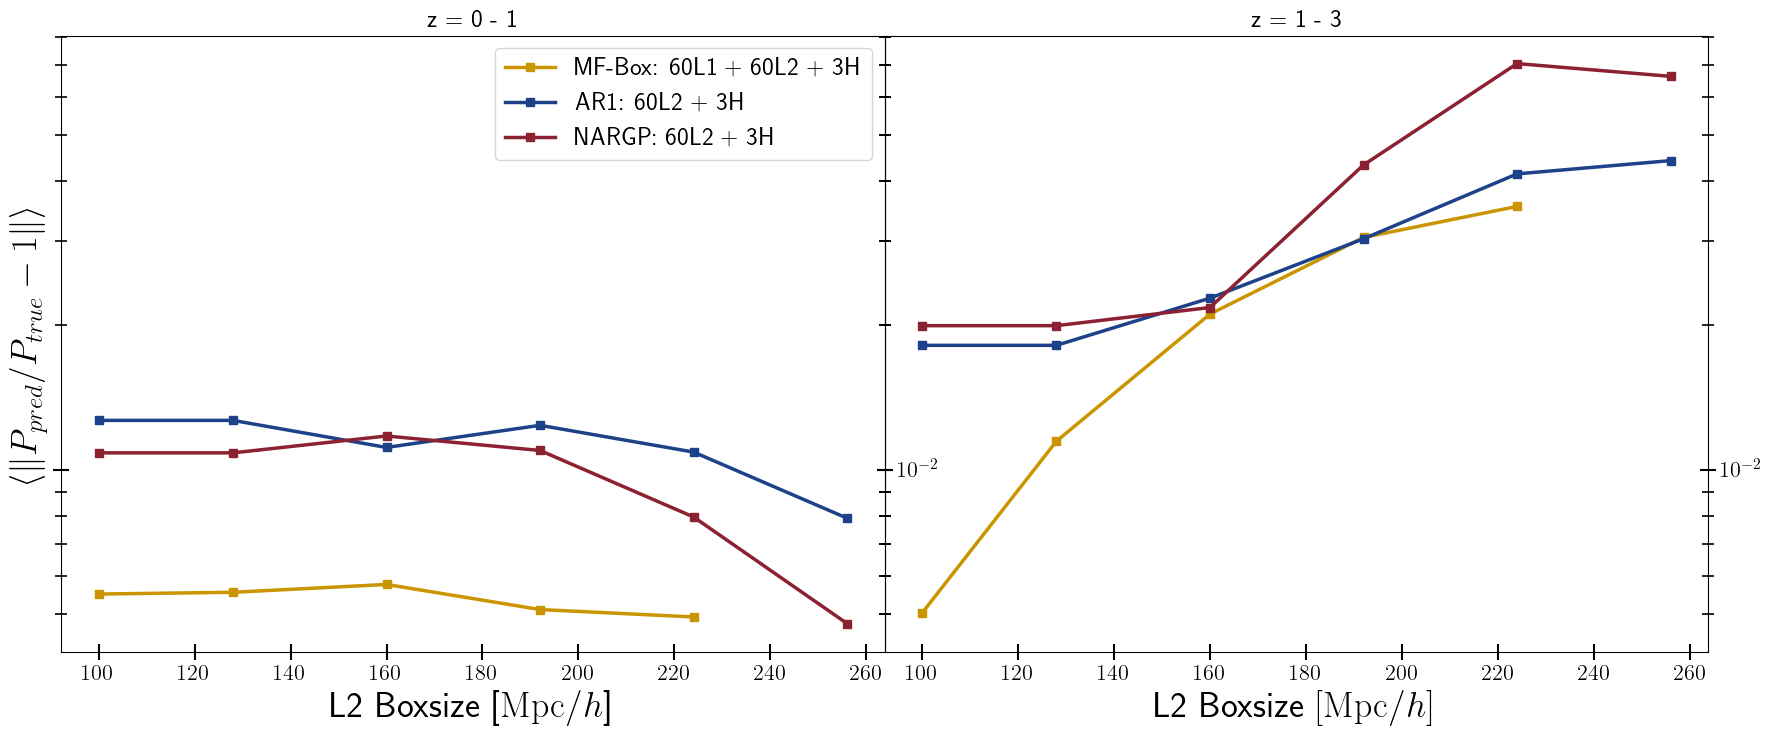

In [19]:
boxsizes = [
    100,
    128,
    160,
    192,
    224,
]

list_emu = [
    vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors,
    vloaders.dgmgp_L60_L2box128_H3_z0_1_2_slice_19.relative_errors,
    vloaders.dgmgp_L60_L2box160_H3_z0_1_2_slice_19.relative_errors,
    vloaders.dgmgp_L60_L2box192_H3_z0_1_2_slice_19.relative_errors,
    vloaders.dgmgp_L60_L2box224_H3_z0_1_2_slice_19.relative_errors,
]

# control: NARGP with 256 Mpc/h
list_ar1 = [
    vloaders.ar1_L60_L2box100_H3_z0_1_2_slice_19.relative_errors,
    vloaders.ar1_L60_L2box128_H3_z0_1_2_slice_19.relative_errors,
    vloaders.ar1_L60_L2box160_H3_z0_1_2_slice_19.relative_errors,
    vloaders.ar1_L60_L2box192_H3_z0_1_2_slice_19.relative_errors,
    vloaders.ar1_L60_L2box224_H3_z0_1_2_slice_19.relative_errors,
    vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors,
]
list_nargp = [
    vloaders.nargp_L60_L2box100_H3_z0_1_2_slice_19.relative_errors,
    vloaders.nargp_L60_L2box128_H3_z0_1_2_slice_19.relative_errors,
    vloaders.nargp_L60_L2box160_H3_z0_1_2_slice_19.relative_errors,
    vloaders.nargp_L60_L2box192_H3_z0_1_2_slice_19.relative_errors,
    vloaders.nargp_L60_L2box224_H3_z0_1_2_slice_19.relative_errors,
    vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors,
]


# Averge z and k
error_averge = [error.mean() for error in list_emu]
std_error_averge = [error.std() for error in list_emu]

# Averge z fix k
error_averge_z = [error.mean(axis=(0, 1)) for error in list_emu]
std_error_averge_z = [error.std(axis=(0, 1)) for error in list_emu]


## all z
zz = np.array(vloaders.dgmgp_L60_H3_z0_1_2_slice_19.z)

# Averge z(ind) fix k
# z in [0, 1)
ind = (zz < 1) & (0 <= zz)
error_averge_k_0_1 = [error[ind, :, :].mean() for error in list_emu]
std_error_averge_k_0_1 = [error[ind, :, :].std() for error in list_emu]
# z in [1, 3]
ind = (zz < 3.1) & (1 <= zz)
error_averge_k_1_3 = [error[ind, :, :].mean() for error in list_emu]
std_error_averge_k_1_3 = [error[ind, :, :].std() for error in list_emu]


## control: nargp
# z in [0, 1)
ind = (zz < 1) & (0 <= zz)
ar1_averge_k_0_1 = [error[ind, :, :].mean() for error in list_ar1]
nargp_averge_k_0_1 = [error[ind, :, :].mean() for error in list_nargp]
# z in [1, 3]
ind = (zz < 3.1) & (1 <= zz)
ar1_averge_k_1_3 = [error[ind, :, :].mean() for error in list_ar1]
nargp_averge_k_1_3 = [error[ind, :, :].mean() for error in list_nargp]


fig, axs = plt.subplots(figsize=(2 * 10.625, 8), nrows=1, ncols=2, sharey=True)


axs[0].plot(
    boxsizes,
    error_averge_k_0_1,
    "s-",
    lw=2.5,
    label=mf_box + ": 60L1 + 60L2 + 3H",
    color=colors[1],
)
axs[0].plot(
    boxsizes + [256],
    ar1_averge_k_0_1,
    "s-",
    lw=2.5,
    label="AR1: 60L2 + 3H",
    color=colors[2],
)
axs[0].plot(
    boxsizes + [256],
    nargp_averge_k_0_1,
    "s-",
    lw=2.5,
    label="NARGP: 60L2 + 3H",
    color=colors[0],
)
axs[1].plot(boxsizes, error_averge_k_1_3, "s-", lw=2.5, color=colors[1])
axs[1].plot(
    boxsizes + [256],
    ar1_averge_k_1_3,
    "s-",
    lw=2.5,
    label="AR1: 60L2 + 3H",
    color=colors[2],
)
axs[1].plot(
    boxsizes + [256],
    nargp_averge_k_1_3,
    "s-",
    lw=2.5,
    label="NARGP: 60L2 + 3H",
    color=colors[0],
)


axs[0].set_xlabel(r"L2 Boxsize [$\mathrm{Mpc}/h$]", fontsize=26)
axs[0].set_ylabel(r"$\langle\| P_{{pred}}/P_{{true}} - 1 \|\rangle$", fontsize=26)
axs[0].set_yscale("log")

axs[1].set_xlabel(r"L2 Boxsize $[\mathrm{Mpc}/h]$", fontsize=26)
axs[1].set_yscale("log")

axs[0].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
axs[0].tick_params(which="minor", length=8)

axs[1].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
axs[1].tick_params(which="minor", length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor("none")
axs[1].patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)

fig.savefig(
    os.path.join(imgdir, "boxsize_split_z.pdf"), bbox_inches="tight", pad_inches=0.075
)
plt.show()

## Figure 15: Error(k) as a function of L2 boxsize


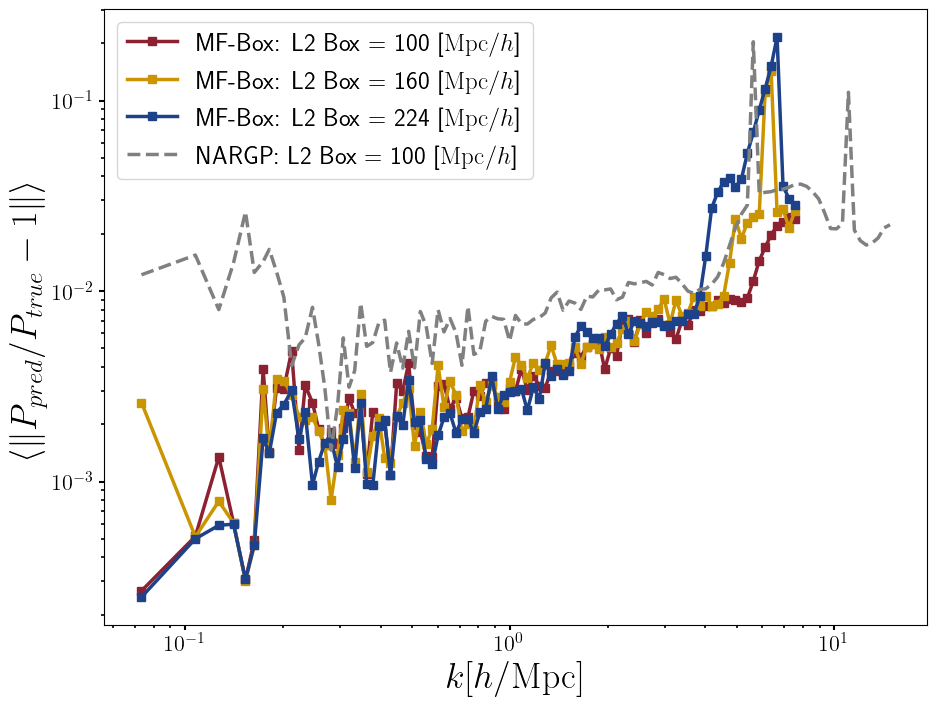

In [22]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

kk = 10 ** vloaders.dgmgp_L60_H3_z0_1_2_slice_19.kf[0]

i = 0
for boxsize in boxsizes:
    if boxsize in [100, 160, 224]:
        ax.plot(
            kk,
            error_averge_z[i],
            "s-",
            lw=2.5,
            color=colors[i],
            label=mf_box + ": L2 Box = {}".format(boxsize) + " [$\mathrm{Mpc}/h$]",
        )

        i += 1

## Include also NARGP
kk = 10 ** vloaders.nargp_L60_L2box100_H3_z0_1_2_slice_19.kf[0]
error_nargp = vloaders.nargp_L60_L2box100_H3_z0_1_2_slice_19.relative_errors
error_nargp = error_nargp.mean(axis=(0, 1))
ax.plot(
    kk,
    error_nargp,
    "--",
    lw=2.5,
    color="grey",
    label="NARGP: L2 Box = 100 [$\mathrm{Mpc}/h$]",
)

ax.set_xlabel(r"$k [h/\mathrm{Mpc}]$", fontsize=26)
ax.set_ylabel(r"$\langle\| P_{{pred}}/P_{{true}} - 1 \|\rangle$", fontsize=26)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
# ax.set_ylim([1e-4, 3e-1])
# ax.set_xlim([kf_test.min()* 0.8, kf_test.max() * 1.1])
fig.savefig(
    os.path.join(imgdir, "boxsize_dgmgp_all_z_versus_k.pdf"),
    bbox_inches="tight",
    pad_inches=0.075,
)
plt.show()


## Research Statement: Yueying style plotting power spectrum


In [33]:
# lores, hires indices: 0:18, 1:4, 2:17, 3:36, 4:26, 5:1
with h5py.File("data/dmo_10_res512box256/cc_emulator_powerspecs.hdf5", "r") as hires:
    hrfp, hrkf = hires["powerspecs"][:], hires["kfmpc"][:]

with h5py.File("data/dmo_10_res128box256/cc_emulator_powerspecs.hdf5", "r") as lores:
    lrfp, lrkf = lores["powerspecs"][:], lores["kfmpc"][:]

with h5py.File("data/dmo_10_res128box100/cc_emulator_powerspecs.hdf5", "r") as lores_2:
    lrfp_2, lrkf_2 = lores_2["powerspecs"][:], lores_2["kfmpc"][:]


# make interpolation to make sure lr and hr have the same shape
## Start here
## -------------
axis_redshift = 1
num_redshifts = hrfp.shape[axis_redshift]

# L1 and HF
this_lrkf, this_hrkf, this_lrfp, this_hrfp, ind = interp_lf_trim_hf(
    k_lf=lrkf, k_hf=hrkf, Y_lf=lrfp[:, 0, :], Y_hf=hrfp[:, 0, :]
)
hrfp_new = np.full(
    (this_hrfp.shape[0], num_redshifts, len(this_hrkf)), fill_value=np.nan
)
lrfp_new = np.full(
    (this_lrfp.shape[0], num_redshifts, len(this_lrkf)), fill_value=np.nan
)

# L2 node
this_lrkf_2, this_hrkf_2, this_lrfp_2, this_hrfp_2, ind = interp_lf_trim_hf(
    k_lf=lrkf_2,
    k_hf=hrkf,
    Y_lf=lrfp_2[:, 0, :],
    Y_hf=hrfp[:, 0, :],
)
lrfp_new_2 = np.full(
    (this_lrfp_2.shape[0], num_redshifts, len(this_lrkf_2)), fill_value=np.nan
)
hrfp_new_2 = np.full(
    (this_hrfp_2.shape[0], num_redshifts, len(this_hrkf_2)), fill_value=np.nan
)


for i in range(num_redshifts):
    # L1 and H
    this_lrkf, this_hrkf, this_lrfp, this_hrfp, ind = interp_lf_trim_hf(
        k_lf=lrkf,
        k_hf=hrkf,
        Y_lf=lrfp[:, i, :],
        Y_hf=hrfp[:, i, :],
    )
    hrfp_new[:, i, :] = this_hrfp
    lrfp_new[:, i, :] = this_lrfp

    # L2 and H
    this_lrkf_2, this_hrkf_2, this_lrfp_2, this_hrfp_2, ind = interp_lf_trim_hf(
        k_lf=lrkf_2,
        k_hf=hrkf,
        Y_lf=lrfp_2[:, i, :],
        Y_hf=hrfp[:, i, :],
    )
    hrfp_new_2[:, i, :] = this_hrfp_2
    lrfp_new_2[:, i, :] = this_lrfp_2


lrfp = lrfp_new
hrfp = hrfp_new

lrkf = this_lrkf
hrkf = this_hrkf

# L2
lrfp_2 = lrfp_new_2
hrfp_2 = hrfp_new_2

lrkf_2 = this_lrkf_2
hrkf_2 = this_hrkf_2

96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.
96 89 89
[Info] rebin powerspecs from 89 k bins to 96 k bins.
117 89 89
[Info] rebin powerspecs from 89 k bins to 117 k bins.


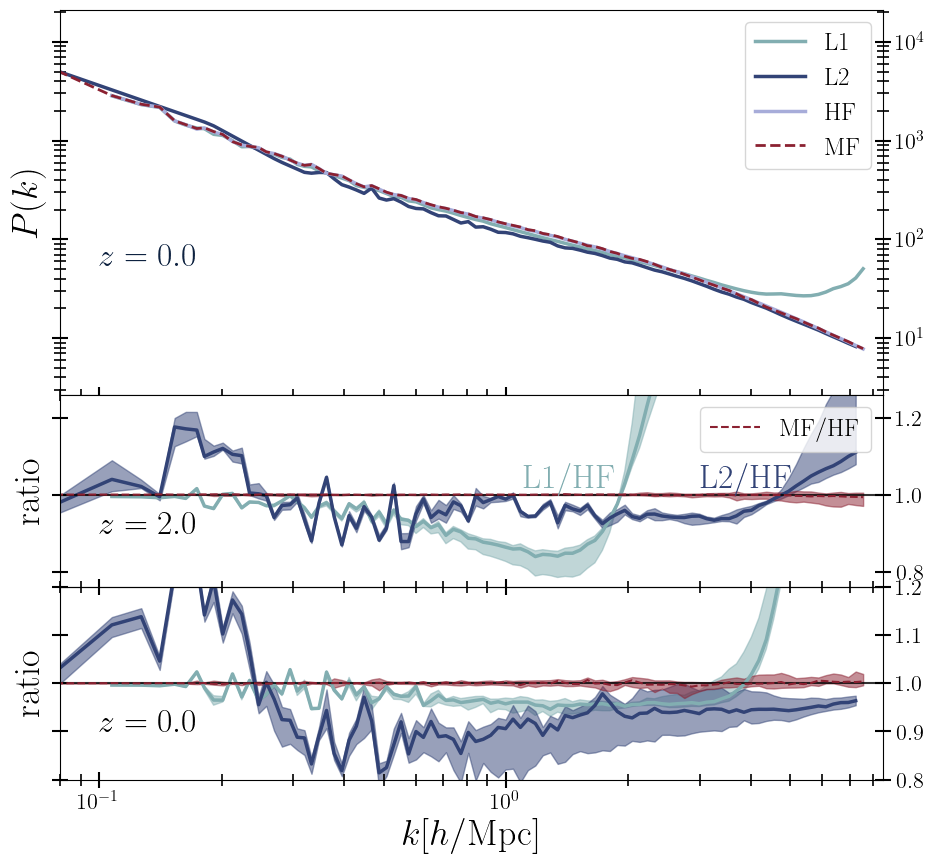

In [125]:
def make_average_all_z_versus_k(
    vloader: ValidationLoader,
    new_fig: bool = False,
    ax=None,
    fig=None,
    color="C0",
    zmin: float = 0.0,
    zmax: float = 3.1,
    **kwargs
):
    """
    Use predict/exact instead.
    """
    if new_fig:
        fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

    # Shape (number of zs, number of test points, number of k bins)

    ## Large scales
    ## Start here
    ## --------------
    z = np.array(vloader.z)
    ind_z = (zmin <= z) & (z < zmax)
    pred_median = np.median(vloader.pred_div_exact[ind_z, :, :], axis=(0, 1))
    pred_lower, pred_upper = np.quantile(
        vloader.pred_div_exact[ind_z, :, :], q=[0.16, 0.84], axis=(0, 1)
    )

    ax.plot(10 ** vloader.kf[0], pred_median, "--", lw=1.5, color=color, **kwargs)
    # plot variance instead of std
    ax.fill_between(
        10 ** vloader.kf[0],
        pred_lower,  # TODO: Correct the paper. I am actually showing the variance.
        pred_upper,
        alpha=0.5,
        color=color,
    )

    return fig, ax


## Multi-panel plots
xr = [0.02, 9]
yr = [0.76, 1.26]
fig, ax = plt.subplots(
    figsize=(10.625, 2.5 * 4),
    nrows=3,
    ncols=1,
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1, 1]},
)
plt.setp(ax, ylim=yr, xlim=xr)

# plot the top panel -- example flux power for LF and HF
z = 0  # index of the redshift
ith = 2  # ith training simulation pair LF/HF

color_l1 = "#82AEB1"
color_l2 = "#324376"
color_h = "#A7ACD9"

# L1 cut
ind_l1 = lrkf > lrkf_2.min()
# Count L2 only until max k of L1
ind = lrkf_2 < lrkf.max()
# H cut
ind_h = hrkf > lrkf_2.min()

ax[0].loglog(
    lrkf[ind_l1],
    lrfp[ith, z, ind_l1],
    "-",
    c=color_l1,
    lw=2.5,
    label="$\mathrm{L1}$",
)
ax[0].loglog(
    lrkf_2[ind],
    lrfp_2[ith, z, :][ind],
    "-",
    c=color_l2,
    lw=2.5,
    label="$\mathrm{L2}$",
)
# High fidelity
ax[0].loglog(
    hrkf[ind_h],
    hrfp[ith, z, ind_h],
    "-",
    c=color_h,
    lw=2.5,
    label="$\mathrm{HF}$",
)
# MF prediction
ax[0].loglog(
    10 ** vloaders.dgmgp_L60_H3_z0_1_2_slice_19.kf[z, :],
    10 ** vloaders.dgmgp_L60_H3_z0_1_2_slice_19.all_gp_mean[z, ith, :],
    "--",
    c=c_flatirons,
    lw=2,
    label="$\mathrm{MF}$",
)

# ax[0].text(hrkf.min() * 1.5, hrfp.max() * .5, 'High Fidelity', c=c_sunshine, fontsize=22)
# ax[0].text(lrkf.min() * 1.2, lrfp.max() * .1, 'Low Fidelity', c=c_skyline, fontsize=22)
ax[0].text(
    0.1,
    (lrfp).max() * 2e-3,
    "$z = {}$".format(str(zz[z])),
    c=c_midnight,
    fontsize=24,
)

ax[0].set_ylabel(r"$P(k)$", fontsize=26)
ax[0].set_yscale("log")
ax[0].set_ylim(
    [
        (lrfp)[ith, z, :].min() * 0.1,
        (lrfp)[ith, z, :].max() * 1.1,
    ]
)
ax[0].set_xlim([0.01, 30])
ax[0].legend()

ax[0].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax[0].tick_params(which="minor", length=8, labelright=False, labelleft=False)


# plot the lower panels -- LF/HF for all pairs
j = 1
for z in np.array([4, 0]):  # z = 3, 0.5, 0
    # L1
    lr_lower, lr_median, lr_upper = np.quantile(
        lrfp[:, z, ind_l1] / hrfp[:, z, ind_l1], q=(0.16, 0.5, 0.84), axis=(0)
    )
    ax[j].plot(lrkf[ind_l1], lr_median, "-", color=color_l1, lw=2.5)
    ax[j].fill_between(
        lrkf[ind_l1],
        lr_lower,
        lr_upper,
        color=color_l1,
        alpha=0.5,
    )

    # L2
    l2_lower, l2_median, l2_upper = np.quantile(
        lrfp_2[:, z, ind] / hrfp_2[:, z, ind], q=(0.16, 0.5, 0.84), axis=(0)
    )
    ax[j].plot(
        lrkf_2[ind],
        l2_median,
        "-",
        color=color_l2,
        lw=2.5,
    )
    ax[j].fill_between(
        lrkf_2[ind],
        l2_lower,
        l2_upper,
        color=color_l2,
        alpha=0.5,
    )

    ax[j].text(0.1, 0.9, "$z = {}$".format(str(zz[z])), fontsize=24)

    ax[j].tick_params(
        which="both",
        direction="inout",
        right=True,
        labelright=True,
        labelleft=False,
        length=12,
    )
    ax[j].tick_params(which="minor", length=8, labelright=False, labelleft=False)
    j += 1

ax[1].text(1.1, 1.02, "$\mathrm{L1/HF}$", c=color_l1, fontsize=24)
ax[1].text(3, 1.02, "$\mathrm{L2/HF}$", c=color_l2, fontsize=24)

# ax[2].set_xlabel('k [h/Mpc]', fontsize=26)
# fig.patch.set_facecolor('none')
# fig.subplots_adjust(hspace=0, wspace=0)


# MFBOX: z = 2
ax[1].plot(np.linspace(0.01, 10, 100), np.ones((100)), color="k", lw=1.5, alpha=0.8)
fig, _ = make_average_all_z_versus_k(
    vloaders.dgmgp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=c_flatirons,
    label="$\mathrm{MF/HF}$",
    ax=ax[1],
    fig=fig,
    zmin=2,
    zmax=2.1,
)
ax[1].set_ylabel(r"$\mathrm{ratio}$", fontsize=26)
# ax[1].set_ylim([0.80, 1.20])
ax[1].legend()

# MFBOX: z = 0
ax[2].plot(np.linspace(0.01, 10, 100), np.ones((100)), color="k", lw=1.5, alpha=0.8)
fig, ax = make_average_all_z_versus_k(
    vloaders.dgmgp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=c_flatirons,
    label="MF/HF",
    ax=ax[2],
    fig=fig,
    zmin=0,
    zmax=0.1,
)


# Martin style
ax.set_xlabel(r"$k [h/\mathrm{Mpc}]$", fontsize=26)
ax.set_ylabel(r"$\mathrm{ratio}$", fontsize=26)
# ax.set_yscale('log')
ax.set_ylim([0.80, 1.20])
ax.set_xlim([0.08, kf_test.max() * 1.1])

ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8)

# ax.set_title("z = 0 - 3")

ax.patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    "/Users/jibanmac/Documents/Latex/GoGoPostdoc2023/images/power_spectrum.png",
    bbox_inches="tight",
    pad_inches=0.075,
    dpi=300,
)
plt.show()

### Functions for plotting averaged errors


In [9]:
# currently using std of |prediction/truth - 1| for uncertainty
# to propagate from prediction uncertainty (error):
# error/prediction * |prediction/truth - 1| / N


def get_mean_std(
    vloader: ValidationLoader,
):
    """
    A modification from Martin's plotting script
    """
    absmean = np.mean(vloader.relative_errors, axis=2)
    absstd = np.std(vloader.relative_errors, axis=2)

    absmeanHF = np.mean(vloader.relative_errors_hf, axis=2)
    absstdHF = np.std(vloader.relative_errors_hf, axis=2)

    return absmean, absstd, absmeanHF, absstdHF

In [122]:
# get error for a specific emulator (averaged over z or k)
def get_mean_std_one(
    lf: Optional[int], hf: Optional[int], z_or_k: str = "k", nargp: bool = False
):
    """
    Modification from Martin's function

    Parameters:
    ----
    lf : number of LF points
    HF : number of HF points
    z_or_k : errors as function of z or k, i.e., average over k or z
    nargp : use nargp results or ar1 results
    """
    axis_z = 0
    axis_test_cases = 1
    axis_k = 2

    if not nargp:
        folder_fn = ar1_folder_name
    elif nargp:
        folder_fn = nargp_folder_name

    # TODO: fix these for now
    res_l = 128
    res_h = 512
    box_l = 256
    box_h = 256
    z = [0, 0.2, 0.5, 1.0, 2.0, 3.0]
    slice = [57, 58, 59]
    num_lf = lf
    num_hf = hf

    # list of emulators in different redshifts
    vloader = ValidationLoader(
        [folder_fn(num_lf, res_l, box_l, num_hf, res_h, box_h, zz, slice) for zz in z],
        num_lowres_list=[num_lf for _ in z],
        num_highres=num_hf,
    )
    vloader.res_l = res_l
    vloader.res_h = res_h
    vloader.box_l = box_l
    vloader.box_h = box_h
    vloader.z = z
    vloader.slice = slice
    vloader.num_lf = num_lf
    vloader.num_hf = num_hf

    # average over k
    # pred_div_exact: Shape (number of emulators (redshifts in this case), number of test simulations, number of k bins)
    if z_or_k == "z":
        absmean = np.full(absmean.shape[axis_z], fill_value=np.nan)
        absstd = np.full(absmean.shape[axis_z], fill_value=np.nan)
        for i in enumerate(absmean):
            absmean[i] = np.mean(np.abs(vloader.pred_div_exact - 1)[i, :, :])
            absstd[i] = np.std(np.abs(vloader.pred_div_exact - 1)[i, :, :])

    elif z_or_k == "k":
        absmean = np.full(absmean.shape[axis_k], fill_value=np.nan)
        absstd = np.full(absmean.shape[axis_k], fill_value=np.nan)
        for i in enumerate(absmean):
            absmean[i] = np.mean(np.abs(vloader.pred_div_exact - 1)[:, :, i])
            absstd[i] = np.std(np.abs(vloader.pred_div_exact - 1)[:, :, i])

    return vloader, absmean, absstd

### Plot of mean error broken down by scale (across all tests, fixed z) versus number of training simulations


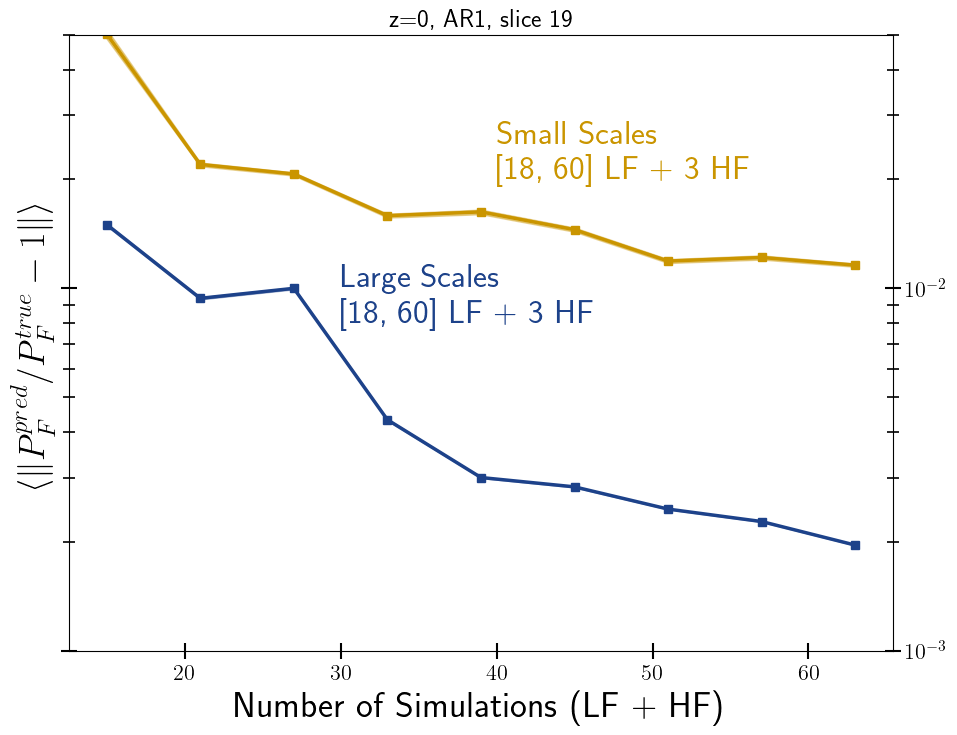

In [13]:
# error with number of training simulations (across all sims, split into small/large scales)
vloader = vloaders.ar1_H3_slice19  # vary LF
# vloader_H369 = vloaders.ar1_H3_6_9 # vary HF

k_pivot = 1

# ind_smallH = 10**vloader_H369.kf[0] >= k_pivot
# ind_largeH = 10**vloader_H369.kf[0] < k_pivot

ind_smallL = 10 ** vloader.kf[0] >= k_pivot
ind_largeL = 10 ** vloader.kf[0] < k_pivot

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

## Large scales
## Start here
## --------------
#
# Shape (number of emulators, number of test points, number of k bins)
# absmeanHF = np.array([
#     np.mean(error[:, ind_largeH]) for error in vloader_H369.relative_errors
# ])
# absstdHF  = np.array([
#     np.std(error[:, ind_largeH]) for error in vloader_H369.relative_errors
# ])

absmeanLF = np.array(
    [np.mean(error[:, ind_largeL]) for error in vloader.relative_errors]
)
absstdLF = np.array([np.std(error[:, ind_largeL]) for error in vloader.relative_errors])

ax.plot(np.array(vloader.num_lf) + vloader.num_hf, absmeanLF, "s-", c=c_skyline, lw=2.5)
# plot variance instead of std
ax.fill_between(
    np.array(vloader.num_lf) + vloader.num_hf,
    (absmeanLF - absstdLF**2),
    (absmeanLF + absstdLF**2),
    color=c_skyline,
    alpha=0.4,
)


# ax.plot(
#     np.array(vloader_H369.num_hf) + vloader_H369.num_lf[0],
#     absmeanHF, 's--', c=c_skyline, lw=2.5
# )


## Small scales
## Start here
## --------------
#
# Shape (number of emulators, number of test points, number of k bins)
# absmeanHF = np.array([
#     np.mean(error[:, ind_smallH]) for error in vloader_H369.relative_errors
# ])
# absstdHF  = np.array([
#     np.std(error[:, ind_smallH]) for error in vloader_H369.relative_errors
# ])

absmeanLF = np.array(
    [np.mean(error[:, ind_smallL]) for error in vloader.relative_errors]
)
absstdLF = np.array([np.std(error[:, ind_smallL]) for error in vloader.relative_errors])


ax.plot(
    np.array(vloader.num_lf) + vloader.num_hf, absmeanLF, "s-", c=c_sunshine, lw=2.5
)
# plot variance instead of std
ax.fill_between(
    np.array(vloader.num_lf) + vloader.num_hf,
    (absmeanLF - absstdLF**2),
    (absmeanLF + absstdLF**2),
    color=c_sunshine,
    alpha=0.4,
)

# ax.plot(
#     np.array(vloader_H369.num_hf) + vloader_H369.num_lf[0],
#     absmeanHF, 's--', c=c_sunshine, lw=2.5
# )

ax.text(30, 8e-3, "Large Scales \n [18, 60] LF + 3 HF", c=c_skyline, fontsize=24)
ax.text(40, 2e-2, "Small Scales \n [18, 60] LF + 3 HF", fontsize=24, c=c_sunshine)
# ax.text(50, 3e-2, 'Dashed \n 60 LF + [3, 9] HF', fontsize=24, c=c_midnight)

ax.set_xlabel("Number of Simulations (LF + HF)", fontsize=26)
ax.set_ylabel(r"$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$", fontsize=26)
ax.set_yscale("log")
ax.set_ylim([1e-3, 5e-2])
# ax.set_xlim([6, 45])
ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8, labelright=False, labelleft=False)
ax.patch.set_facecolor("none")

ax.set_title("z=0, AR1, slice 19")

fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/ar1_H3_slice19_nsim_scales_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

In [14]:
def make_scale_split_versus_LF(
    vloader: ValidationLoader,
    k_pivot: float,
    new_fig: bool = False,
    ax=None,
    fig=None,
    **kwargs
):
    ind_smallL = 10 ** vloader.kf[0] >= k_pivot
    ind_largeL = 10 ** vloader.kf[0] < k_pivot

    if new_fig:
        fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

    ## Large scales
    ## Start here
    ## --------------
    absmeanLF = np.array(
        [np.mean(error[:, ind_largeL]) for error in vloader.relative_errors]
    )
    absstdLF = np.array(
        [np.std(error[:, ind_largeL]) for error in vloader.relative_errors]
    )

    ax.plot(
        np.array(vloader.num_lf) + vloader.num_hf,
        absmeanLF,
        "s-",
        c=c_skyline,
        lw=2.5,
        **kwargs
    )
    # plot variance instead of std
    ax.fill_between(
        np.array(vloader.num_lf) + vloader.num_hf,
        (absmeanLF - absstdLF**2),
        (absmeanLF + absstdLF**2),
        color=c_skyline,
        alpha=0.4,
    )

    ## Small scales
    ## Start here
    ## --------------
    absmeanLF = np.array(
        [np.mean(error[:, ind_smallL]) for error in vloader.relative_errors]
    )
    absstdLF = np.array(
        [np.std(error[:, ind_smallL]) for error in vloader.relative_errors]
    )

    ax.plot(
        np.array(vloader.num_lf) + vloader.num_hf,
        absmeanLF,
        "s-",
        c=c_sunshine,
        lw=2.5,
        **kwargs
    )
    # plot variance instead of std
    ax.fill_between(
        np.array(vloader.num_lf) + vloader.num_hf,
        (absmeanLF - absstdLF**2),
        (absmeanLF + absstdLF**2),
        color=c_sunshine,
        alpha=0.4,
    )

    return fig, ax

 /var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_73485/3636869175.py:22: UserWarning:linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
 /var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_73485/3636869175.py:51: UserWarning:linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.


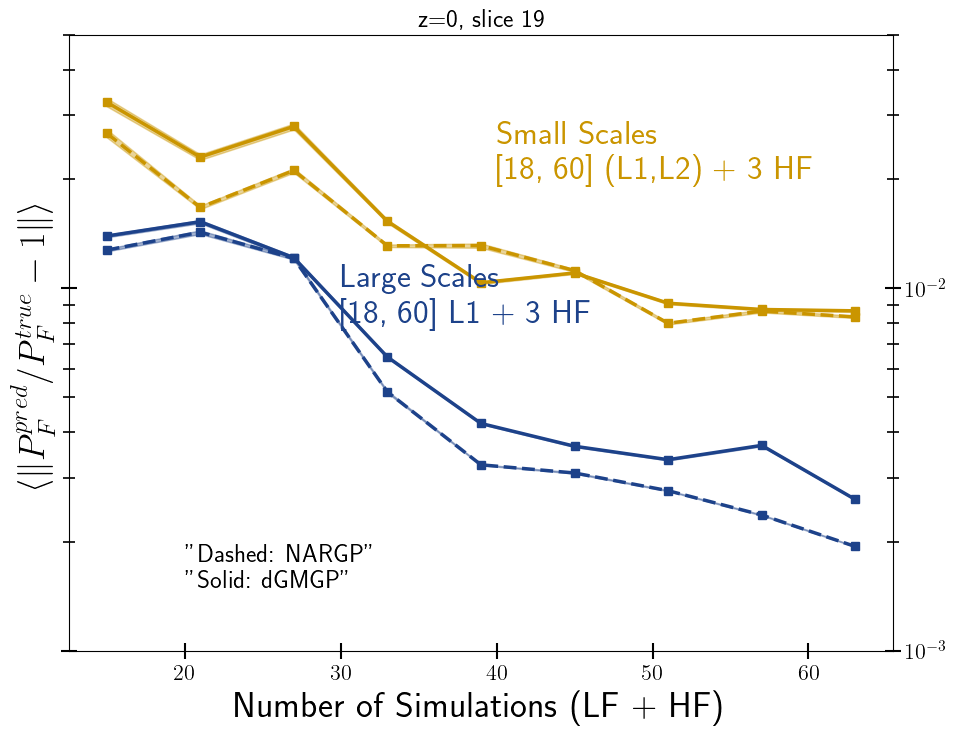

In [16]:
# error with number of training simulations (across all sims, split into small/large scales)
vloader = vloaders.nargp_H3_slice19  # vary LF

k_pivot = 1


fig, ax = make_scale_split_versus_LF(
    vloaders.nargp_H3_slice19,
    k_pivot,
    new_fig=True,
    ls="--",
)
fig, ax = make_scale_split_versus_LF(
    vloaders.dgmgp_H3_slice19,
    k_pivot,
    new_fig=False,
    ax=ax,
    fig=fig,
)

ax.text(30, 8e-3, "Large Scales \n [18, 60] L1 + 3 HF", c=c_skyline, fontsize=24)
ax.text(40, 2e-2, "Small Scales \n [18, 60] (L1,L2) + 3 HF", fontsize=24, c=c_sunshine)
ax.text(20, 1.5e-3, '"Dashed: NARGP"\n"Solid: dGMGP"', fontsize=18, c="k")
# ax.text(50, 3e-2, 'Dashed \n 60 LF + [3, 9] HF', fontsize=24, c=c_midnight)

ax.set_xlabel("Number of Simulations (LF + HF)", fontsize=26)
ax.set_ylabel(r"$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$", fontsize=26)
ax.set_yscale("log")
ax.set_ylim([1e-3, 5e-2])
# ax.set_xlim([6, 45])
ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8, labelright=False, labelleft=False)
ax.patch.set_facecolor("none")

ax.set_title("z=0, slice 19")
# ax.legend(["Dashed: AR1", "Solid: NARGP"])

fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/nargp_H3_slice19_nsim_scales_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

### Mean errors versus HR points


In [17]:
def make_scale_split_versus_HF(
    vloader: ValidationLoader,
    k_pivot: float,
    new_fig: bool = False,
    ax=None,
    fig=None,
    **kwargs
):
    ind_smallL = 10 ** vloader.kf[0] >= k_pivot
    ind_largeL = 10 ** vloader.kf[0] < k_pivot

    if new_fig:
        fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

    ## Large scales
    ## Start here
    ## --------------
    absmeanLF = np.array(
        [np.mean(error[:, ind_largeL]) for error in vloader.relative_errors]
    )
    absstdLF = np.array(
        [np.std(error[:, ind_largeL]) for error in vloader.relative_errors]
    )

    ax.plot(vloader.num_hf, absmeanLF, "s-", c=c_skyline, lw=2.5, **kwargs)
    # plot variance instead of std
    ax.fill_between(
        vloader.num_hf,
        (absmeanLF - absstdLF**2),
        (absmeanLF + absstdLF**2),
        color=c_skyline,
        alpha=0.4,
    )

    ## Small scales
    ## Start here
    ## --------------
    absmeanLF = np.array(
        [np.mean(error[:, ind_smallL]) for error in vloader.relative_errors]
    )
    absstdLF = np.array(
        [np.std(error[:, ind_smallL]) for error in vloader.relative_errors]
    )

    ax.plot(vloader.num_hf, absmeanLF, "s-", c=c_sunshine, lw=2.5, **kwargs)
    # plot variance instead of std
    ax.fill_between(
        vloader.num_hf,
        (absmeanLF - absstdLF**2),
        (absmeanLF + absstdLF**2),
        color=c_sunshine,
        alpha=0.4,
    )

    return fig, ax

In [17]:
# TODO: another plot with varying HF points

 /var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_73485/3686741542.py:22: UserWarning:linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
 /var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_73485/3686741542.py:51: UserWarning:linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.


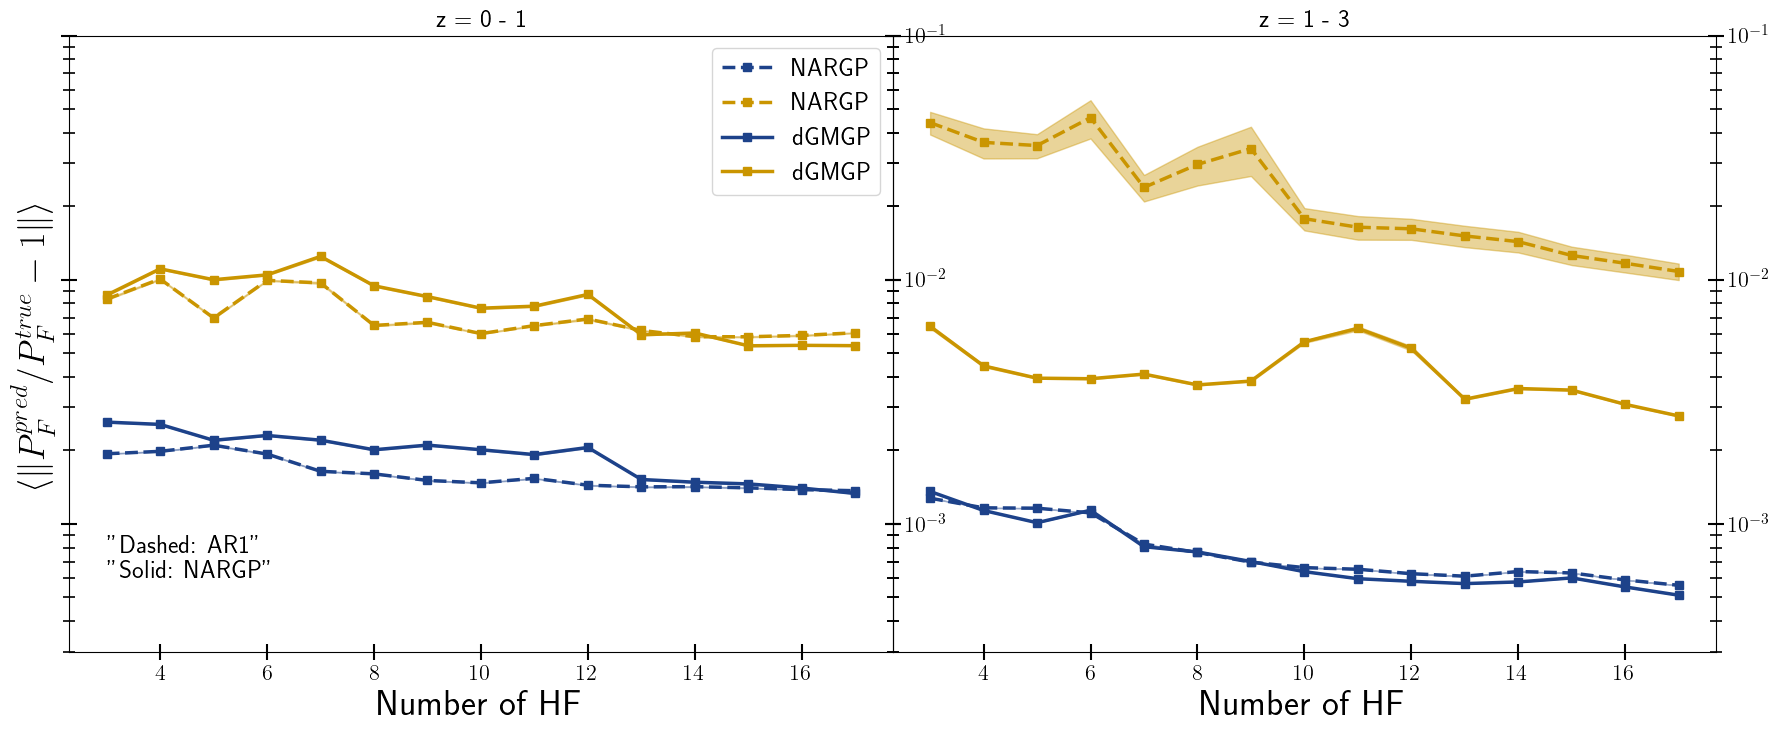

In [18]:
fig, axs = plt.subplots(figsize=(2 * 10.625, 8), nrows=1, ncols=2, sharey=True)

# error with number of training simulations (across all sims, split into small/large scales)
k_pivot = 1

fig, ax = make_scale_split_versus_HF(
    vloaders.nargp_L60_H3_10_z0,
    k_pivot,
    new_fig=False,
    ls="--",
    ax=axs[0],
    fig=fig,
    label="NARGP",
)
fig, ax = make_scale_split_versus_HF(
    vloaders.dgmgp_L60_H3_10_z0, k_pivot, new_fig=False, ax=ax, fig=fig, label="dGMGP"
)

fig, ax = make_scale_split_versus_HF(
    vloaders.nargp_L60_H3_10_z2, k_pivot, new_fig=False, ls="--", ax=axs[1], fig=fig
)
fig, ax = make_scale_split_versus_HF(
    vloaders.dgmgp_L60_H3_10_z2,
    k_pivot,
    new_fig=False,
    ax=ax,
    fig=fig,
)

# ax.text(30, 8e-3, 'Large Scales \n [18, 60] LF + 3 HF', c=c_skyline, fontsize=24)
# ax.text(40, 2e-2, 'Small Scales \n [18, 60] LF + 3 HF', fontsize=24, c=c_sunshine)
axs[0].text(3, 6e-4, '"Dashed: AR1"\n"Solid: NARGP"', fontsize=18, c="k")
# ax.text(50, 3e-2, 'Dashed \n 60 LF + [3, 9] HF', fontsize=24, c=c_midnight)

axs[0].set_xlabel("Number of HF", fontsize=26)
axs[0].set_ylabel(r"$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$", fontsize=26)
axs[0].set_yscale("log")
axs[0].set_ylim([3e-4, 1e-1])

axs[1].set_xlabel("Number of HF", fontsize=26)
# axs[1].set_ylabel(r'$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$', fontsize=26)
axs[1].set_yscale("log")
axs[1].set_ylim([3e-4, 1e-1])

axs[0].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
axs[0].tick_params(which="minor", length=8)

axs[1].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
axs[1].tick_params(which="minor", length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor("none")
axs[1].patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/nargp_H3_slice19_HR_scales_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

### Don't break down scales


In [19]:
def make_versus_HF(
    vloader: ValidationLoader, new_fig: bool = False, ax=None, fig=None, **kwargs
):
    if new_fig:
        fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

    ## Start here
    ## --------------
    absmeanLF = np.array([np.mean(error[:, :]) for error in vloader.relative_errors])
    absstdLF = np.array([np.std(error[:, :]) for error in vloader.relative_errors])

    ax.plot(vloader.num_hf, absmeanLF, "s-", lw=2.5, **kwargs)
    # plot variance instead of std
    ax.fill_between(
        vloader.num_hf,
        (absmeanLF - absstdLF**2),
        (absmeanLF + absstdLF**2),
        alpha=0.4,
    )

    return fig, ax

 /var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_73485/4017946290.py:18: UserWarning:linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.


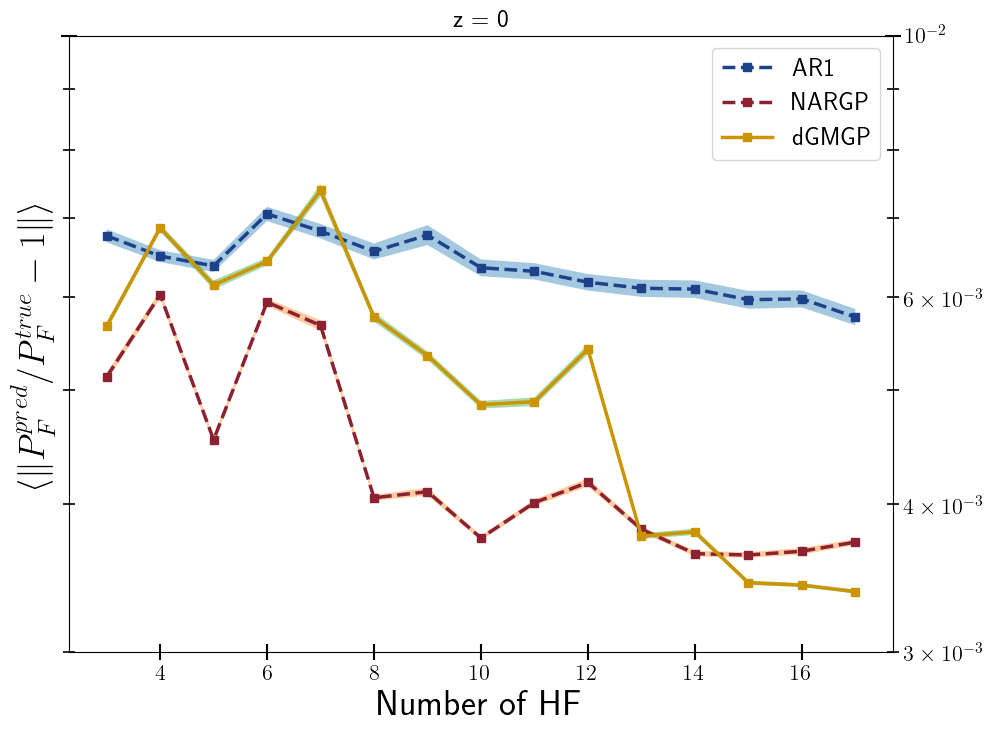

In [21]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1, sharey=True)

# error with number of training simulations (across all sims, )
fig, ax = make_versus_HF(
    vloaders.ar1_L60_H3_10_z0,
    new_fig=False,
    ls="--",
    ax=ax,
    fig=fig,
    label="AR1",
    c=colors[2],
)
fig, ax = make_versus_HF(
    vloaders.nargp_L60_H3_10_z0,
    new_fig=False,
    ls="--",
    ax=ax,
    fig=fig,
    label="NARGP",
    c=colors[0],
)
fig, ax = make_versus_HF(
    vloaders.dgmgp_L60_H3_10_z0,
    new_fig=False,
    ax=ax,
    fig=fig,
    label="dGMGP",
    c=colors[1],
)

# ax.text(3, 6e-4, '"Dashed: AR1"\n"Solid: NARGP"', fontsize=18, c="k")
# ax.text(50, 3e-2, 'Dashed \n 60 LF + [3, 9] HF', fontsize=24, c=c_midnight)

ax.set_xlabel("Number of HF", fontsize=26)
ax.set_ylabel(r"$\langle\| P_F^{{pred}}/P_F^{{true}} - 1 \|\rangle$", fontsize=26)
ax.set_yscale("log")
ax.set_ylim([3e-3, 1e-2])

ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8)

ax.legend()
ax.set_title("z = 0")

ax.patch.set_facecolor("none")

fig.subplots_adjust(hspace=0, wspace=0)

# fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/nargp_H3_slice19_HR_error.pdf", bbox_inches='tight', pad_inches=0.075)
plt.show()

In [21]:
# TODO: another plot with sum over redshifts


### Fig (MFBox): Break down the error by k bins (fixed k)


### Proposal Plot (z = 0)


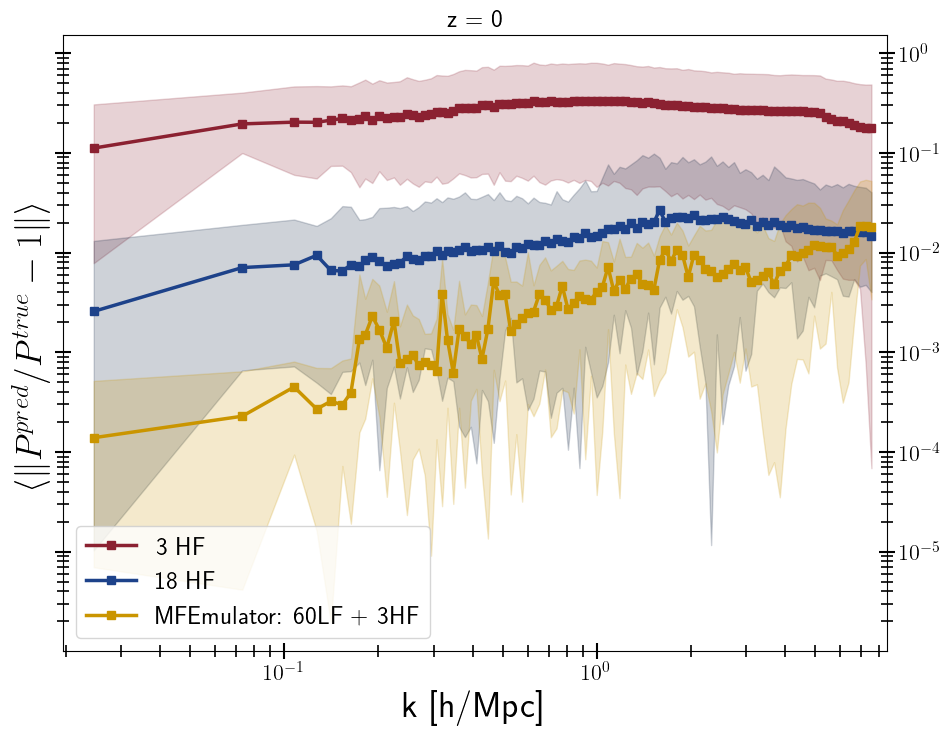

In [58]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# 3 HF only
vloader = vloaders.nargp_L60_L2box100_H3_z0_1_2_slice_0_1_2

absmeanLF = vloader.relative_errors_hf[[0], :, :].mean(axis=(0, 1))
absstdLF_min = vloader.relative_errors_hf[[0], :, :].min(axis=(0, 1))
absstdLF_max = vloader.relative_errors_hf[[0], :, :].max(axis=(0, 1))

ax.semilogx(10 ** vloader.kf[0], absmeanLF, "s-", lw=2.5, color=colors[0], label="3 HF")
# plot variance instead of std
ax.fill_between(
    10 ** vloader.kf[0],
    absstdLF_min,
    absstdLF_max,
    alpha=0.2,
    color=colors[0],
)

# 18 HF only
vloader = vloaders.ar1_H18_slice19

absmeanLF = vloader.relative_errors_hf[:, :, :].mean(axis=(0, 1))
absstdLF_min = vloader.relative_errors_hf[:, :, :].min(axis=(0, 1))
absstdLF_max = vloader.relative_errors_hf[:, :, :].max(axis=(0, 1))


ax.semilogx(
    10 ** vloader.kf[0], absmeanLF, "s-", lw=2.5, color=colors[2], label="18 HF"
)
# plot variance instead of std
ax.fill_between(
    10 ** vloader.kf[0],
    absstdLF_min,
    absstdLF_max,
    alpha=0.2,
    color=colors[3],
)


# MFEmulator : 60-3

vloader = vloaders.nargp_L60_H3_z0_1_2_slice_19

absmeanLF = vloader.relative_errors[[0], :, :].mean(axis=(0, 1))
absstdLF_min = vloader.relative_errors[[0], :, :].min(axis=(0, 1))
absstdLF_max = vloader.relative_errors[[0], :, :].max(axis=(0, 1))

ax.semilogx(
    10 ** vloader.kf[0],
    absmeanLF,
    "s-",
    lw=2.5,
    color=colors[1],
    label="MFEmulator: 60LF + 3HF",
)
# plot variance instead of std
ax.fill_between(
    10 ** vloader.kf[0],
    absstdLF_min,
    absstdLF_max,
    alpha=0.2,
    color=colors[1],
)


# Martin style
ax.set_xlabel(r"k [h/Mpc]", fontsize=26)
ax.set_ylabel(r"$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$", fontsize=26)
ax.set_yscale("log")
# ax.set_ylim([1e-4, 3e-1])
ax.set_xlim([kf_test.min() * 0.8, kf_test.max() * 1.1])

ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8)

ax.legend()
ax.set_title("z = 0 ")

ax.patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join("../../Latex/postdoc_app_2022/images/", "MF_proposal_past.pdf"),
    bbox_inches="tight",
    pad_inches=0.075,
)
plt.show()

### Fig (MFBox) Break down into different redshift bins


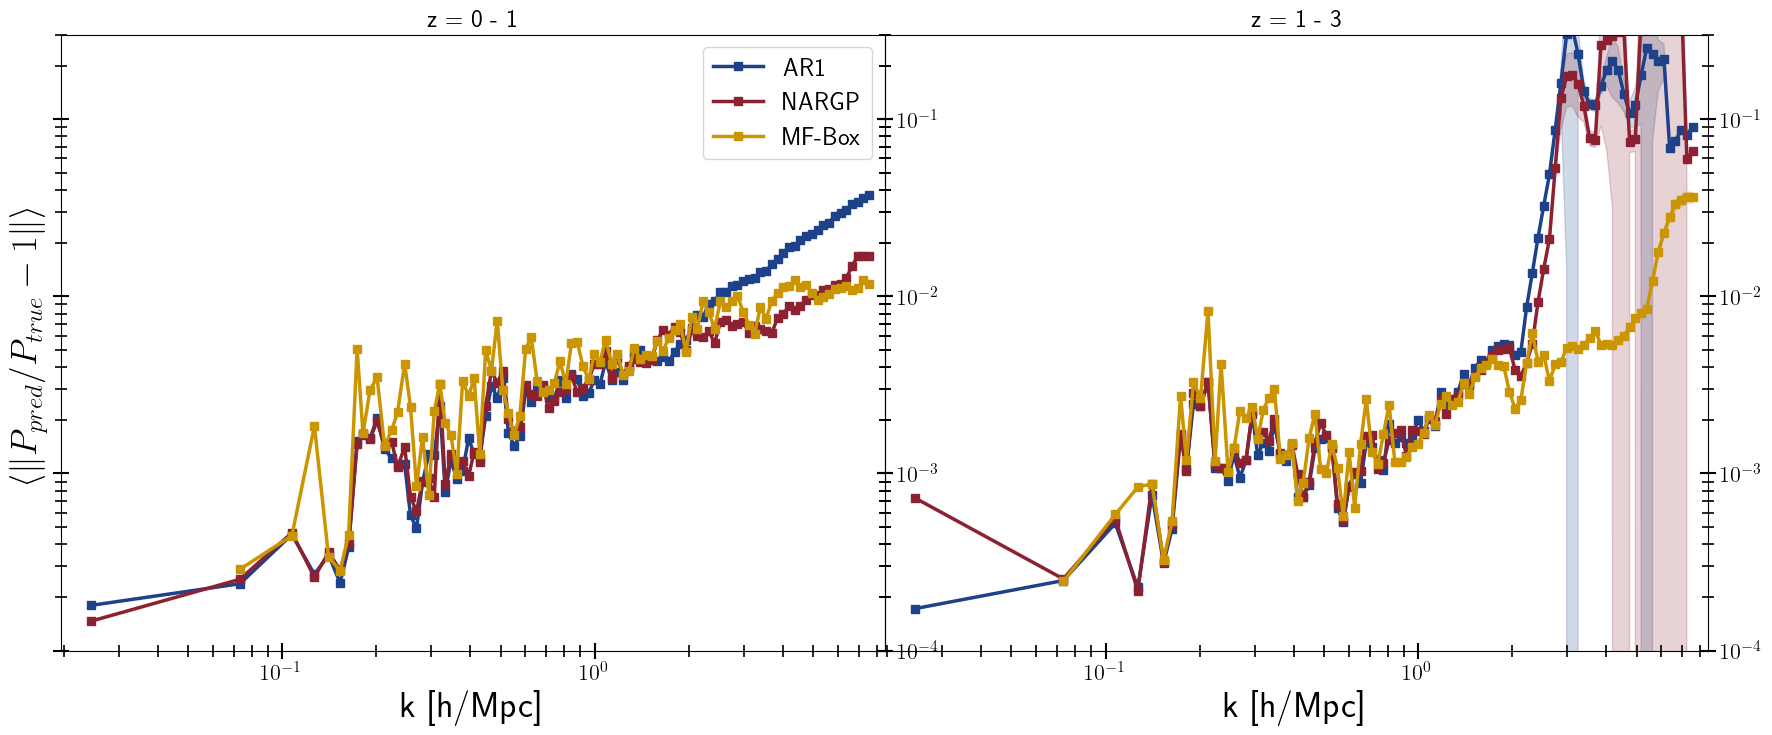

In [115]:
fig, axs = plt.subplots(figsize=(2 * 10.625, 8), nrows=1, ncols=2, sharey=True)

fig, ax = make_average_all_z_versus_k(
    vloaders.ar1_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[2],
    label="AR1",
    ax=axs[0],
    fig=fig,
    zmin=0.0,
    zmax=1.0,
)
fig, ax = make_average_all_z_versus_k(
    vloaders.nargp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[0],
    label="NARGP",
    ax=ax,
    fig=fig,
    zmin=0.0,
    zmax=1.0,
)

fig, ax = make_average_all_z_versus_k(
    vloaders.dgmgp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[1],
    label=mf_box,
    ax=ax,
    fig=fig,
    zmin=0.0,
    zmax=1.0,
)

fig, ax = make_average_all_z_versus_k(
    vloaders.ar1_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[2],
    label="AR1",
    ax=axs[1],
    fig=fig,
    zmin=1.0,
    zmax=3.1,
)
fig, ax = make_average_all_z_versus_k(
    vloaders.nargp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[0],
    label="NARGP",
    ax=ax,
    fig=fig,
    zmin=1.0,
    zmax=3.1,
)

fig, ax = make_average_all_z_versus_k(
    vloaders.dgmgp_L60_H3_z0_1_2_slice_19,
    new_fig=False,
    color=colors[1],
    label=mf_box,
    ax=ax,
    fig=fig,
    zmin=1.0,
    zmax=3.1,
)

# Martin style
axs[0].set_xlabel(r"k [h/Mpc]", fontsize=26)
axs[0].set_ylabel(r"$\langle\| P_{{pred}}/P_{{true}} - 1 \|\rangle$", fontsize=26)
axs[0].set_yscale("log")
axs[0].set_ylim([1e-4, 3e-1])
axs[0].set_xlim([kf_test.min() * 0.8, kf_test.max() * 1.1])

axs[1].set_xlabel(r"k [h/Mpc]", fontsize=26)
# axs[1].set_ylabel(r'$\langle\| P^{{pred}}/P^{{true}} - 1 \|\rangle$', fontsize=26)
axs[1].set_yscale("log")
axs[1].set_ylim([1e-4, 3e-1])
axs[1].set_xlim([kf_test.min() * 0.8, kf_test.max() * 1.1])

axs[0].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
axs[0].tick_params(which="minor", length=8)

axs[1].tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
axs[1].tick_params(which="minor", length=8)

axs[0].legend()
axs[0].set_title("z = 0 - 1")
axs[1].set_title("z = 1 - 3")

axs[0].patch.set_facecolor("none")
axs[1].patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join("dgmgp_all_z_versus_k_split_scales.pdf"),
    bbox_inches="tight",
    pad_inches=0.075,
)
plt.show()

### Break down the errors by redshift


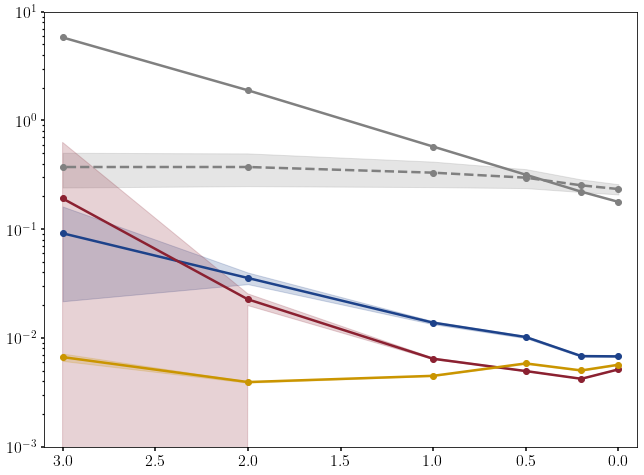

In [25]:
# z versus small and large scale error (all sims) for 40-4, LF and HF only
# L1 error exlcuded because variance is too large due to bias in the tail, which is not fair
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1, sharey=True)
plt.setp(ax, ylim=[1e-3, 10], xlim=[3.1, -0.1], yscale="log")

zz = vloaders.ar1_L60_H3_z0_1_2_slice_19.z

k_pivot = 20  # h/Mpc

## Large scales
## Start here
## -------------
##
# Shape (number of redshifts, number of test points, number of k bins)
kf = vloaders.ar1_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf < k_pivot
lfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].mean(
    axis=(1, 2)
)
lfstd = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_lf[:, :, ind].std(
    axis=(1, 2)
)

hfmean = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].mean(
    axis=(1, 2)
)
hfstd = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors_hf[:, :, ind].std(
    axis=(1, 2)
)

absmeanLF = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(
    axis=(1, 2)
)
absstdLF = vloaders.ar1_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(
    axis=(1, 2)
)

absmeanNARGP = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(
    axis=(1, 2)
)
absstdNARGP = vloaders.nargp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(
    axis=(1, 2)
)

kf = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.kf[0]
ind = 10**kf < k_pivot
absmeandGMGP = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].mean(
    axis=(1, 2)
)
absstddGMGP = vloaders.dgmgp_L60_H3_z0_1_2_slice_19.relative_errors[:, :, ind].std(
    axis=(1, 2)
)

ax.plot(zz, lfmean, "o-", c="grey", lw=2.5, label="60L1")
# ax[0].fill_between(zz, (lfmean-lfstd**2), (lfmean+lfstd**2), color=c_flatirons, alpha=0.4,)

ax.plot(zz, hfmean, "o--", color="grey", lw=2.5, label="3H")
ax.fill_between(
    zz, (hfmean - hfstd**2), (hfmean + hfstd**2), color="grey", alpha=0.2
)

ax.plot(zz, absmeanLF, "o-", c=colors[2], lw=2.5, label="AR1: 60L1+3H")
ax.fill_between(
    zz,
    (absmeanLF - absstdLF**2),
    (absmeanLF + absstdLF**2),
    color=colors[2],
    alpha=0.2,
)

ax.plot(zz, absmeanNARGP, "o-", c=colors[0], lw=2.5, label="NARGP: 60L1+3H")
ax.fill_between(
    zz,
    (absmeanNARGP - absstdNARGP**2),
    (absmeanNARGP + absstdNARGP**2),
    color=colors[0],
    alpha=0.2,
)

ax.plot(zz, absmeandGMGP, "o-", c=colors[1], lw=2.5, label="dGMGP: 60L1+60L2+3H")
ax.fill_between(
    zz,
    (absmeandGMGP - absstddGMGP**2),
    (absmeandGMGP + absstddGMGP**2),
    color=colors[1],
    alpha=0.2,
)

### Compare errors to non-linear GP


## Fig (MFBox): Last fig, inferred loss


### Zoom in version of MF Emulators


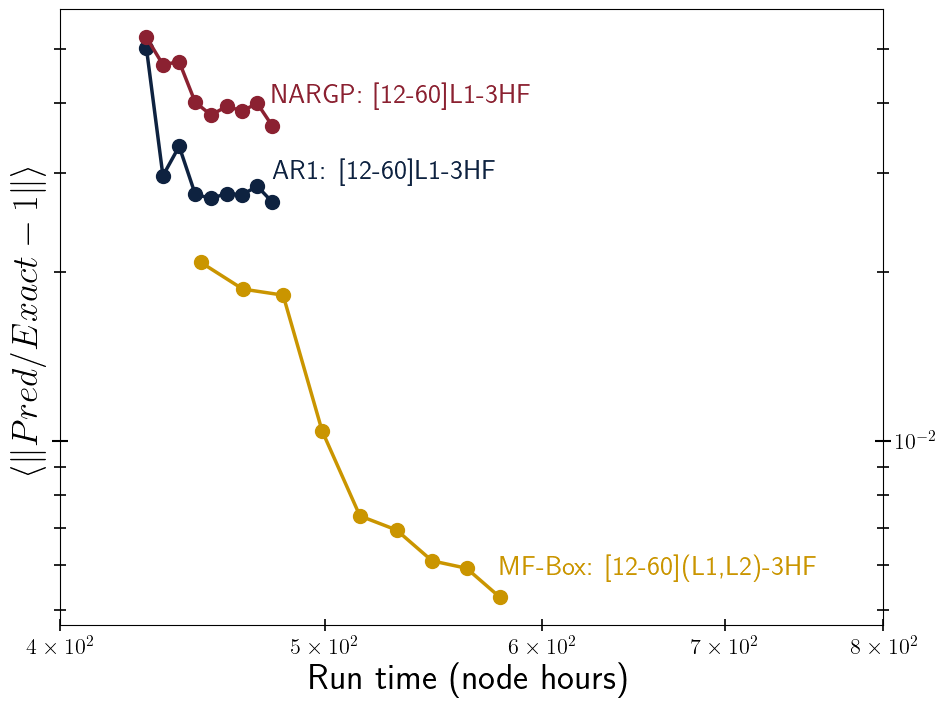

In [13]:
# # optimization times converted to hours -- too subdominant to matter
# times_4hf = np.array([84, 85, 92, 106, 133, 166, 156, 160, 173, 180, 174, 179, 179, 194, 197, 194, 193, 195, 187])/60
# times_3hf = np.array([118, 174, 172, 192])/60
# times_2hf = np.array([92, 178, 193, 202])/60

# LF1: used 8 nodes, MPIs: 16 Threads: 32 Elapsed: 446.128
# [TODO] Currently only a rough estimate
time_per_lfsim = np.mean([446.128, 402.408, 518.769, 436.079]) * 8 / 3600
time_per_hfsim = np.mean([47452.16, 58640.92, 82104.07]) * 8 / 3600

time_per_lfsim2 = np.mean([638.619, 767.55, 953.475, 724.265, 706.971]) * 8 / 3600

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)


# MF: Vary LF
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + 3 * time_per_hfsim,
    ar1_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_midnight,
    ms=10,
    label="AR1 [12-60]L1-3H",
)
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + 3 * time_per_hfsim,
    nargp_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_flatirons,
    ms=10,
    label="NARGP [12-60]L1-3H",
)
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2
    + 3 * time_per_hfsim,
    dgmgp_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_sunshine,
    ms=10,
    label="dGMGP [12-60]L1-[12-60]L2-3H",
)

ax.text(
    1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
    1.1 * ar1_vary_lf.mean(axis=(0, 2, 3))[-1],
    "AR1: [12-60]L1-3HF",
    fontsize=20,
    color=c_midnight,
)
ax.text(
    1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
    1.1 * nargp_vary_lf.mean(axis=(0, 2, 3))[-1],
    "NARGP: [12-60]L1-3HF",
    fontsize=20,
    color=c_flatirons,
)
ax.text(
    1 * (3 * time_per_hfsim + 60 * time_per_lfsim + 60 * time_per_lfsim2),
    1.1 * dgmgp_vary_lf.mean(axis=(0, 2, 3))[-1],
    mf_box + ": [12-60](L1,L2)-3HF",
    fontsize=20,
    color=c_sunshine,
)

ax.set_xlabel("Run time (node hours)", fontsize=26)
ax.set_ylabel(r"$\langle\| Pred/Exact - 1 \|\rangle$", fontsize=26)
ax.set_yscale("log")
ax.set_xscale("log")

# ax.set_ylim([7e-3, 1e-1])
ax.set_xlim([400, 800])

ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8, labelright=False, labelleft=False)

fig.patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join(imgdir, "runtime_error_zoom_in.pdf"),
    bbox_inches="tight",
    pad_inches=0.075,
)
plt.show()

## Proposal plot


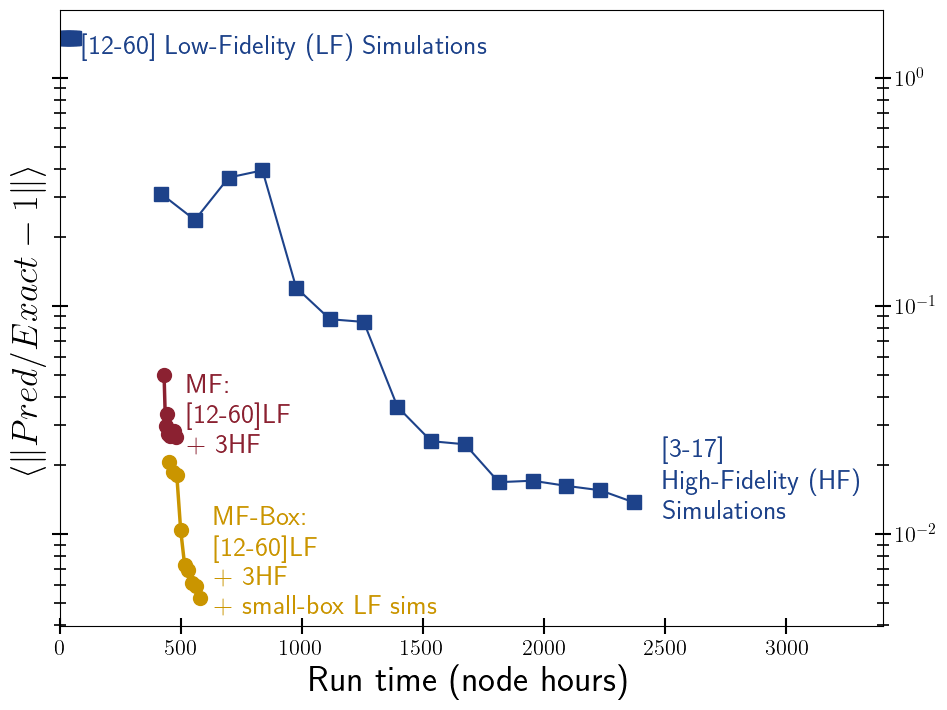

In [30]:
# # optimization times converted to hours -- too subdominant to matter
# times_4hf = np.array([84, 85, 92, 106, 133, 166, 156, 160, 173, 180, 174, 179, 179, 194, 197, 194, 193, 195, 187])/60
# times_3hf = np.array([118, 174, 172, 192])/60
# times_2hf = np.array([92, 178, 193, 202])/60

# LF1: used 8 nodes, MPIs: 16 Threads: 32 Elapsed: 446.128
# [TODO] Currently only a rough estimate
time_per_lfsim = np.mean([446.128, 402.408, 518.769, 436.079]) * 8 / 3600
time_per_hfsim = np.mean([47452.16, 58640.92, 82104.07]) * 8 / 3600

time_per_lfsim2 = np.mean([638.619, 767.55, 953.475, 724.265, 706.971]) * 8 / 3600

fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

# LF only
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim,
    lf_only_error.mean(axis=(0, 2, 3)),
    "s-",
    c=c_skyline,
    ms=10,
)
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2,
#     lf_only_error_2.mean(axis=(0, 2, 3)),
#     's-',
#     c=c_skyline,
#     ms=10
# )

# HF only
ax.plot(
    np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]) * time_per_hfsim,
    hf_only_error.mean(axis=(0, 2, 3)),
    "s-",
    c=c_skyline,
    ms=10,
)
# MF: Vary LF
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + 3 * time_per_hfsim,
    ar1_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_flatirons,
    ms=10,
    label="AR1 [12-60]L1-3H",
)
# ax.plot(
#     np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim +
#     3 * time_per_hfsim,
#     nargp_vary_lf.mean(axis=(0, 2, 3)),
#     'o-',
#     lw=2.5,
#     c=c_flatirons,
#     ms=10,
#     label="NARGP [12-60]L1-3H",
# )
ax.plot(
    np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim
    + np.array([12, 18, 24, 30, 36, 42, 48, 54, 60]) * time_per_lfsim2
    + 3 * time_per_hfsim,
    dgmgp_vary_lf.mean(axis=(0, 2, 3)),
    "o-",
    lw=2.5,
    c=c_sunshine,
    ms=10,
    label=mf_box + " [12-60]L1-[12-60]L2-3H",
)

# Texts
ax.text(
    1.5 * 60 * time_per_lfsim,
    0.85 * lf_only_error.mean(axis=(0, 2, 3))[-1],
    "[12-60] Low-Fidelity (LF) Simulations",
    fontsize=20,
    color=c_skyline,
)
# ax.text(
#     1.5 * 60 * time_per_lfsim2,
#     0.85*lf_only_error_2.mean(axis=(0, 2, 3))[-1],
#     '[12-60] L2',
#     fontsize=20,
#     color=c_skyline,
# )
ax.text(
    1.05 * 17 * time_per_hfsim,
    0.85 * hf_only_error.mean(axis=(0, 2, 3))[-1],
    "[3-17] \nHigh-Fidelity (HF) \nSimulations",
    fontsize=20,
    color=c_skyline,
)
ax.text(
    1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
    0.85 * ar1_vary_lf.mean(axis=(0, 2, 3))[-1],
    "MF: \n[12-60]LF \n+ 3HF",
    fontsize=20,
    color=c_flatirons,
)
# ax.text(
#     1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim),
#     0.85*nargp_vary_lf.mean(axis=(0, 2, 3))[-1],
#     'NARGP: [12-60]L1-3HF',
#     fontsize=20,
#     color=c_flatirons,
# )
ax.text(
    1.1 * (3 * time_per_hfsim + 60 * time_per_lfsim + 60 * time_per_lfsim2),
    0.85 * dgmgp_vary_lf.mean(axis=(0, 2, 3))[-1],
    mf_box + ": \n[12-60]LF\n+ 3HF\n+ small-box LF sims",
    fontsize=20,
    color=c_sunshine,
)

ax.set_xlabel("Run time (node hours)", fontsize=26)
ax.set_ylabel(r"$\langle\| Pred/Exact - 1 \|\rangle$", fontsize=26)
ax.set_yscale("log")
# ax.set_xscale('log')

# ax.set_ylim([7e-3, 1e-1])
ax.set_xlim([0, 3400])

ax.tick_params(
    which="both",
    direction="inout",
    right=True,
    labelright=True,
    labelleft=False,
    length=12,
)
ax.tick_params(which="minor", length=8, labelright=False, labelleft=False)

fig.patch.set_facecolor("none")
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig(
    os.path.join("../../Latex/postdoc_app_2022/images/", "runtime_error.pdf"),
    bbox_inches="tight",
    pad_inches=0.075,
)
plt.show()